# **ÁNALISE EXPLORATÓRIA E PRÉ PROCESSAMENTO DE DADOS DE UM E-COMMERCE**

## Informações gerais

Esse notebook é baseado em um conjunto de dados disponibilizado por um e-commerce brasileiro sob a licença CC BY-NC-SA 4.0.

O conjunto de dados foi disponibilizado em 8 arquivos .csv que se relacionam da seguinte forma:

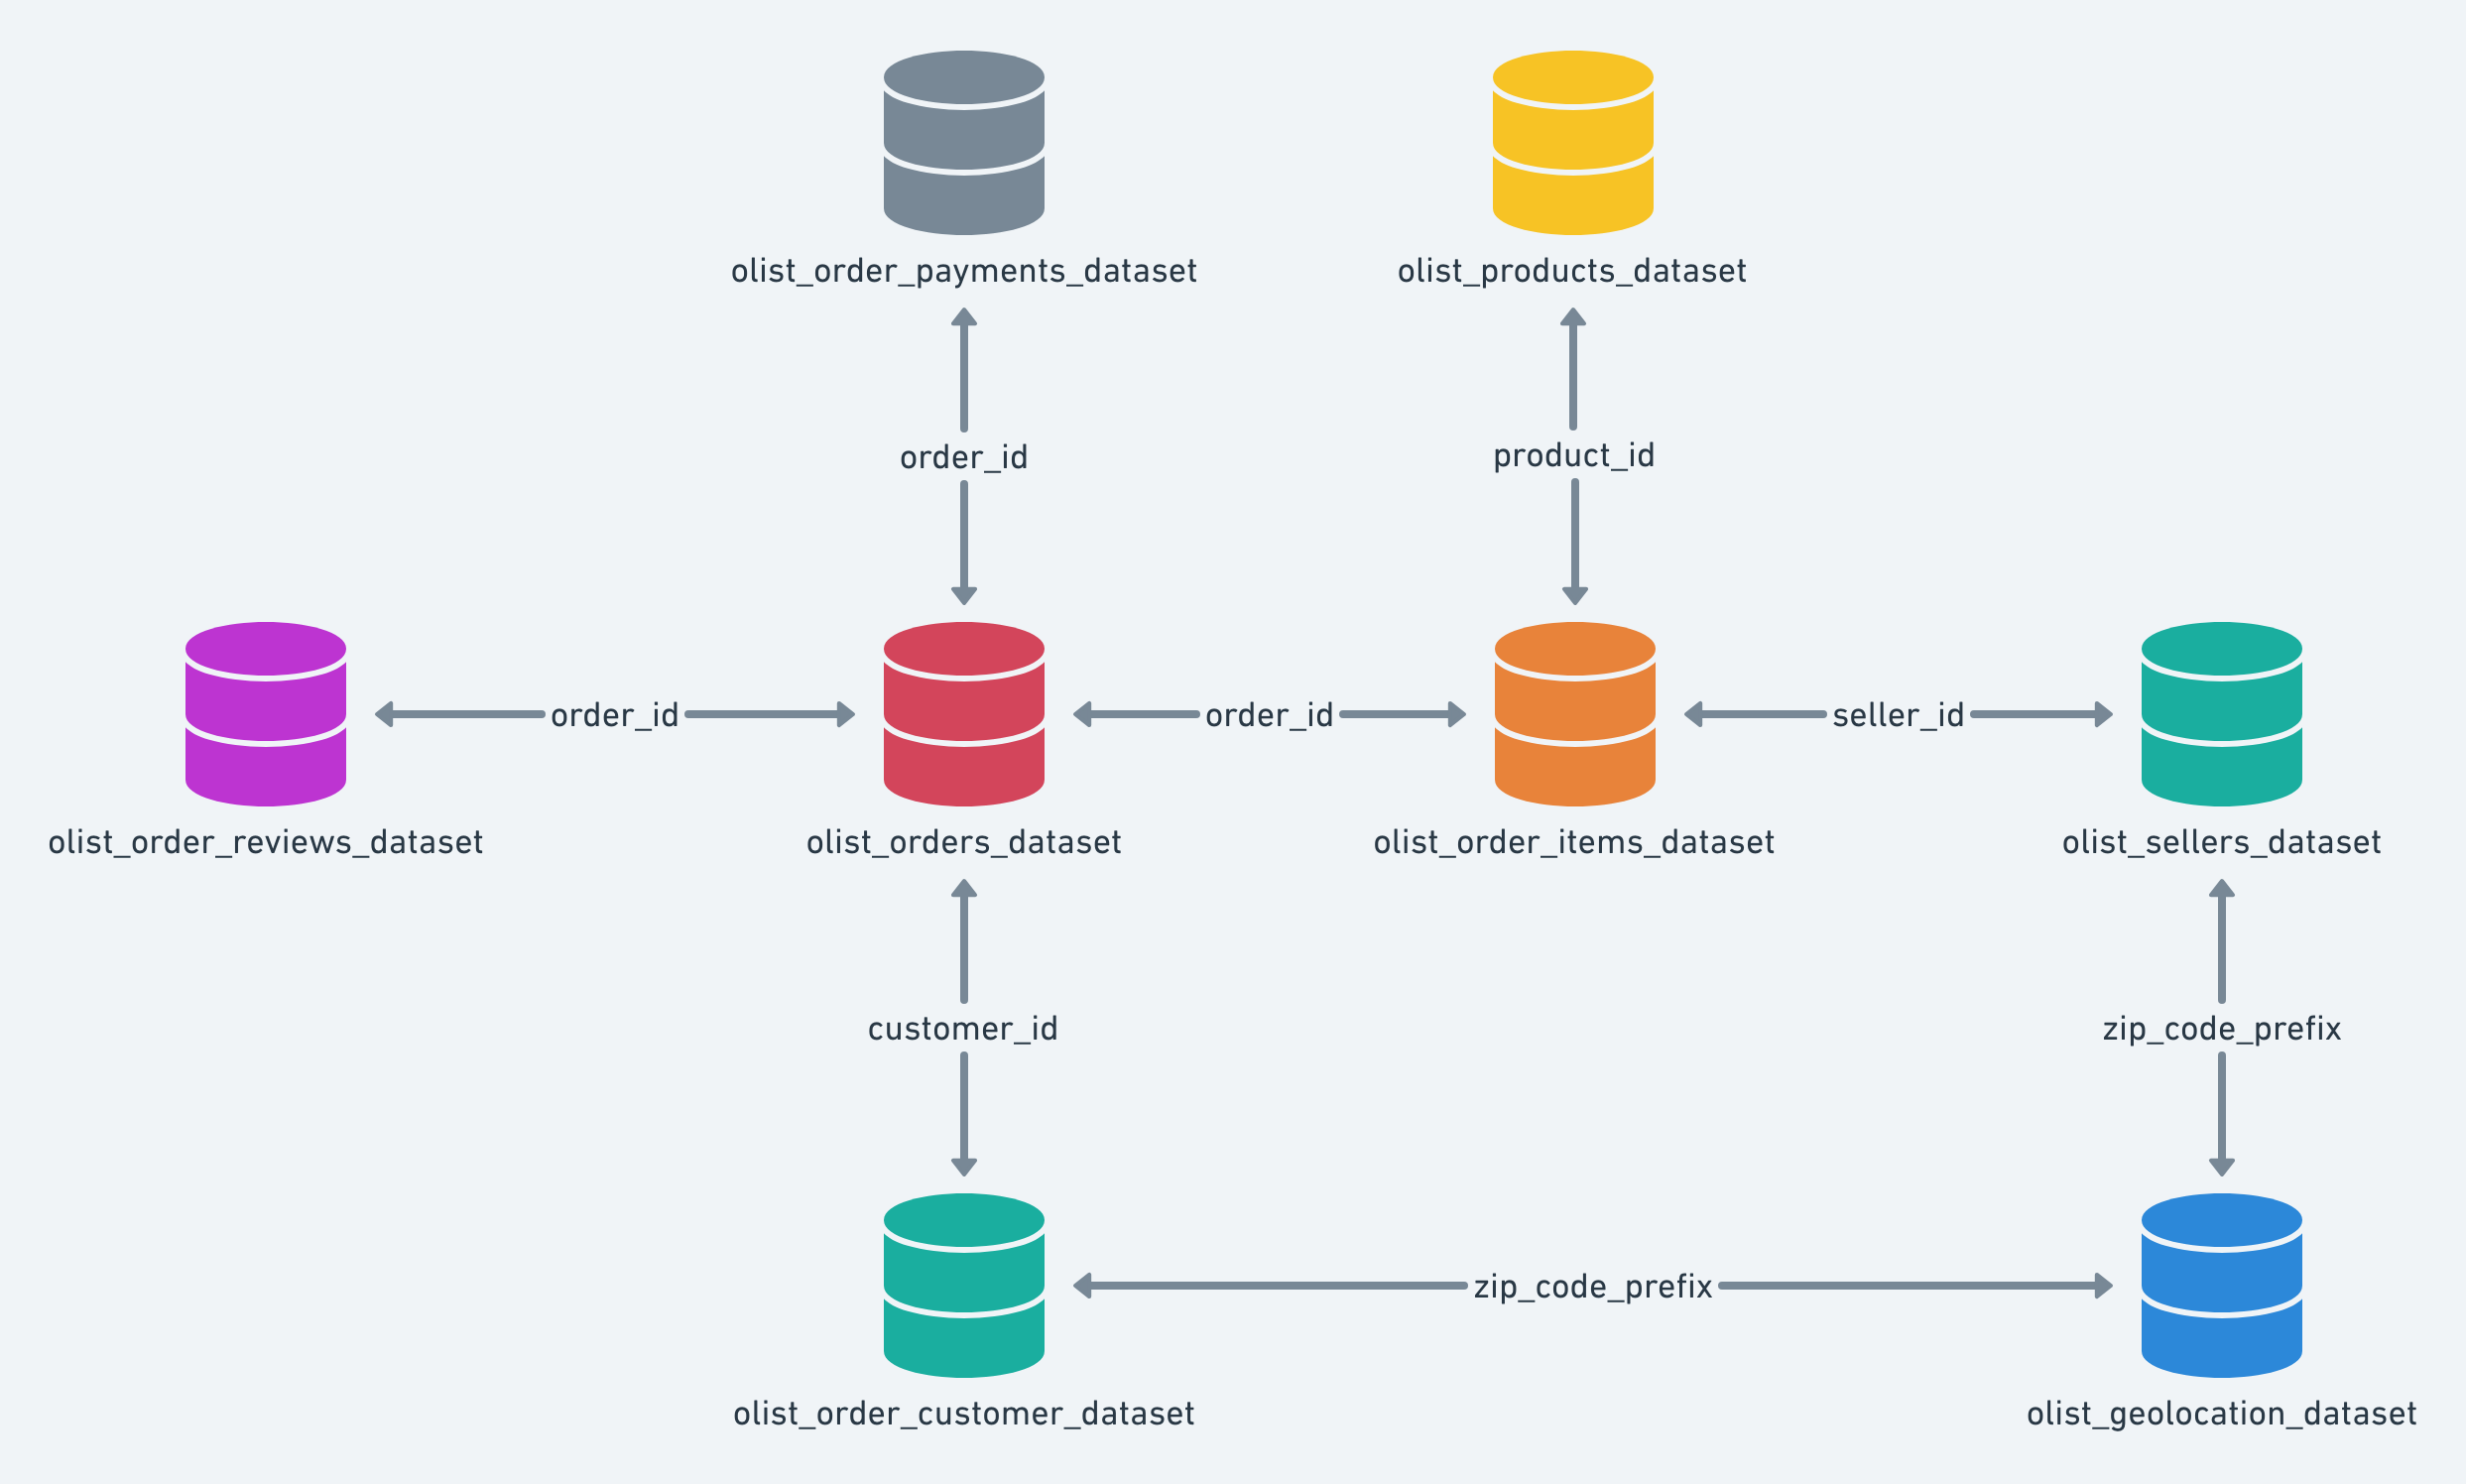

## Definição do problema

A partir dos dados fornecidos, será realizada uma análise exploratória a fim de entender quais fatores mais afetam a satisfação dos clientes. Ou seja, quais atributos estão relacionados às piores avaliações feitas pelos clientes sobre os produtos vendidos.

Este problema não tem um caráter preditivo. Portanto, não se aplicam técnicas de machine learning, mas será realizada uma análise descritiva dos dados.

## Análise exploratória

In [1]:
# importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
# importando os arquivos .csv para dataframes
# o parametro parse_dates lista os atributos que são datas e os transforma em objetos datetime
orders = pd.read_csv ('olist_orders_dataset.csv', 
                      parse_dates=['order_purchase_timestamp',
                                   'order_approved_at',
                                   'order_delivered_carrier_date',
                                   'order_delivered_customer_date',
                                   'order_estimated_delivery_date'])
order_items = pd.read_csv ('olist_order_items_dataset.csv', parse_dates=['shipping_limit_date'])
products = pd.read_csv ('olist_products_dataset.csv')
customers = pd.read_csv ('olist_customers_dataset.csv')
sellers = pd.read_csv ('olist_sellers_dataset.csv')
order_payments = pd.read_csv ('olist_order_payments_dataset.csv')
order_reviews = pd.read_csv ('olist_order_reviews_dataset.csv', parse_dates=['review_creation_date','review_answer_timestamp'])
geolocation = pd.read_csv ('olist_geolocation_dataset.csv')

### Entendendo o conjunto de dados

In [3]:
# resumo estatístico do dataset 'orders'
# include=all inclui todos os atributos do dataframe no resumo
# datetime_is_numeric=True trata os atributos datetime como numéricos neste resumo
orders.describe(include='all', datetime_is_numeric=True)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99441,99441,99441,99281,97658,96476,99441
unique,99441,99441,8,NaN,NaN,NaN,NaN,NaN
top,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,NaN,NaN,NaN,NaN,NaN
freq,1,1,96478,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,2017-12-31 08:43:12.776581120,2017-12-31 18:35:24.098800128,2018-01-04 21:49:48.138278656,2018-01-14 12:09:19.035542272,2018-01-24 03:08:37.730111232
min,NaN,NaN,NaN,2016-09-04 21:15:19,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-09-30 00:00:00
25%,NaN,NaN,NaN,2017-09-12 14:46:19,2017-09-12 23:24:16,2017-09-15 22:28:50.249999872,2017-09-25 22:07:22.249999872,2017-10-03 00:00:00
50%,NaN,NaN,NaN,2018-01-18 23:04:36,2018-01-19 11:36:13,2018-01-24 16:10:58,2018-02-02 19:28:10.500000,2018-02-15 00:00:00
75%,NaN,NaN,NaN,2018-05-04 15:42:16,2018-05-04 20:35:10,2018-05-08 13:37:45,2018-05-15 22:48:52.249999872,2018-05-25 00:00:00
max,NaN,NaN,NaN,2018-10-17 17:30:18,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-11-12 00:00:00


O arquivo orders contém os seguintes atributos:

order_id  
idetificador único do pedido - chave para as tabelas order_items, order_payments e order_reviews.

customer_id  
chave para o dataset customer. cada pedido tem um customer_id único - chave para a tabela customers.

order_status  
status do pedido (entregue, enviado, cancelado etc).

order_purchase_timestamp  
timestamp do ato da compra.

order_approved_at  
timestamp da aprovação do pagamento.

order_delivered_carrier_date  
timestamp da postagem do pedido, quando ele foi entregue ao parceiro logístico.

order_delivered_customer_date  
data que o pedido foi entregue ao cliente.

order_estimated_delivery_date  
data estimada de entrega informada ao cliente no ato da compra.

Pelo resumo, é possível observar que o dataset contém 99.441 pedidos únicos realizados de set/2016 a out/2018, todos com order_id, customer_id, order_status, order_purchase_timestamp e order_estimated_delivery_date preenchidos. Para os outros atributos, existem nulos. Como há 8 status de pedido diferentes, é válido checar a composição dos pedidos:

In [4]:
# contagem dos status dos pedidos
orders.groupby('order_status').size()

order_status
approved           2
canceled         625
created            5
delivered      96478
invoiced         314
processing       301
shipped         1107
unavailable      609
dtype: int64

Mais de 95% dos pedidos possuem status de entregue ("delivered"). Algo que chama atenção é que o número de pedidos com status de entregue (96.478) é diferente da contagem de linhas do atributo order_delivered_customer_date que estão preenchidas (96.476). Esse número deveria ser igual, todo pedido entregue deveria ter uma data de entrega preenchida. Faz sentido investigar esse número para entender essa diferença de 2 pedidos e conhecer um pouco melhor o dataset:

In [5]:
# filtra os pedidos que não possuem data de entrega ao cliente preenchida mas possuem status de 'entregue'
orders[(pd.isna(orders['order_delivered_customer_date'])) & (orders['order_status']=='delivered')]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaT,2018-07-30
79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaT,2018-07-30
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaT,2018-07-24
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaT,2018-06-26
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19


Existem 8 pedidos com status de entregue mas com data de entrega nula. Isso significa que existem 6 pedidos com data de entrega preenchida mas com outro status, dessa forma a diferença é de 2 pedidos:

In [6]:
# filtra os pedidos que possuem data de entrega ao cliente preenchida mas NÃO possuem status de entregue
orders[(pd.notna(orders['order_delivered_customer_date'])) & (~orders.order_status.isin(['delivered']))]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
2921,1950d777989f6a877539f53795b4c3c3,1bccb206de9f0f25adc6871a1bcf77b2,canceled,2018-02-19 19:48:52,2018-02-19 20:56:05,2018-02-20 19:57:13,2018-03-21 22:03:51,2018-03-09
8791,dabf2b0e35b423f94618bf965fcb7514,5cdec0bb8cbdf53ffc8fdc212cd247c6,canceled,2016-10-09 00:56:52,2016-10-09 13:36:58,2016-10-13 13:36:59,2016-10-16 14:36:59,2016-11-30
58266,770d331c84e5b214bd9dc70a10b829d0,6c57e6119369185e575b36712766b0ef,canceled,2016-10-07 14:52:30,2016-10-07 15:07:10,2016-10-11 15:07:11,2016-10-14 15:07:11,2016-11-29
59332,8beb59392e21af5eb9547ae1a9938d06,bf609b5741f71697f65ce3852c5d2623,canceled,2016-10-08 20:17:50,2016-10-09 14:34:30,2016-10-14 22:45:26,2016-10-19 18:47:43,2016-11-30
92636,65d1e226dfaeb8cdc42f665422522d14,70fc57eeae292675927697fe03ad3ff5,canceled,2016-10-03 21:01:41,2016-10-04 10:18:57,2016-10-25 12:14:28,2016-11-08 10:58:34,2016-11-25
94399,2c45c33d2f9cb8ff8b1c86cc28c11c30,de4caa97afa80c8eeac2ff4c8da5b72e,canceled,2016-10-09 15:39:56,2016-10-10 10:40:49,2016-10-14 10:40:50,2016-11-09 14:53:50,2016-12-08


Para uma análise futura que envolva relacionar os status dos pedidos com a data de entrega é importante endereçar essa inconsistência.

In [7]:
order_items.describe(include='all', datetime_is_numeric=True)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
count,112650,112650.000000,112650,112650,112650,112650.000000,112650.000000
unique,98666,NaN,32951,3095,NaN,NaN,NaN
top,8272b63d03f5f79c56e9e4120aec44ef,NaN,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0,NaN,NaN,NaN
freq,21,NaN,527,2033,NaN,NaN,NaN
mean,NaN,1.197834,NaN,NaN,2018-01-07 15:36:52.192685312,120.653739,19.990320
min,NaN,1.000000,NaN,NaN,2016-09-19 00:15:34,0.850000,0.000000
25%,NaN,1.000000,NaN,NaN,2017-09-20 20:57:27.500000,39.900000,13.080000
50%,NaN,1.000000,NaN,NaN,2018-01-26 13:59:35,74.990000,16.260000
75%,NaN,1.000000,NaN,NaN,2018-05-10 14:34:00.750000128,134.900000,21.150000
max,NaN,21.000000,NaN,NaN,2020-04-09 22:35:08,6735.000000,409.680000


O arquivo order_items possui os seguintes atributos:

order_id  
identificador único do pedido - chave para a tabela orders  

order_item_id  
número sequencial identificando o número dos itens inclusos no mesmo pedido   

product_id  
identificador único do produto - chave para a tabela products

seller_id  
identificador único do vendedor - chave para a tabela sellers  

shipping_limit_date  
data limite para o vendedor entregar o pedido para o parceiro logístico

price  
preço do item

freight_value  
valor do frete do item - se o pedido tem mais de um item, o valor do frete é dividido entre os itens de acordo com suas medidas e peso.

Não existem nulos neste arquivo. São 112.650 itens em 98.666 pedidos diferentes. É importante notar que o número de pedidos deste arquivo é menor do que o do aquivo orders (99.441). Além disso, são 32.951 itens diferentes vendidos por 3.095 vendedores distintos com um preço médio por produto de R\\$ 120 e preço médio de frete por produto de R\\$ 20.

In [8]:
products.describe(include='all')

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32951,32341,32341.000000,32341.000000,32341.000000,32949.000000,32949.000000,32949.000000,32949.000000
unique,32951,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,1e9e8ef04dbcff4541ed26657ea517e5,cama_mesa_banho,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,3029,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,48.476949,771.495285,2.188986,2276.472488,30.815078,16.937661,23.196728
std,NaN,NaN,10.245741,635.115225,1.736766,4282.038731,16.914458,13.637554,12.079047
min,NaN,NaN,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,NaN,NaN,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,NaN,NaN,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,NaN,NaN,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000


O arquivo products possui os seguintes atributos:

product_id  
identificador único do pedido - chave para a tabela order_items  

product_category_name  
categoria do produto, em português

product_name_lenght  
número de caracteres do nome do produto

product_description_lenght  
número de caracteres da descrição do produto

product_photos_qty  
número de fotos publicadas do produto

product_weight_g  
peso do produto em gramas

product_length_cm  
comprimento do produto em centímetros

product_height_cm  
altura do produto em centímetros

product_width_cm  
largura do produto em centímetros

Existem 32.951 produtos únicos listados neste arquivo que são classificados em 73 categorias diferentes. Há nulos em todos os atributos. 

In [9]:
customers.describe(include='all')

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
count,99441,99441,99441.000000,99441,99441
unique,99441,96096,NaN,4119,27
top,06b8999e2fba1a1fbc88172c00ba8bc7,8d50f5eadf50201ccdcedfb9e2ac8455,NaN,sao paulo,SP
freq,1,17,NaN,15540,41746
mean,NaN,NaN,35137.474583,NaN,NaN
std,NaN,NaN,29797.938996,NaN,NaN
min,NaN,NaN,1003.000000,NaN,NaN
25%,NaN,NaN,11347.000000,NaN,NaN
50%,NaN,NaN,24416.000000,NaN,NaN
75%,NaN,NaN,58900.000000,NaN,NaN


Os atributos do arquivo customers são os seguintes:

customer_id  
cada pedido possui um único identificador - chave para a tabela orders

customer_unique_id  
identificador único de um cliente

customer_zip_code_prefix  
primeiros 5 dígitos do cep do cliente

customer_city  
nome da cidade do cliente

customer_state  
nome do Estado do cliente

Nota-se que existem 99.441 pedidos únicos, assim como na tabela orders. Os pedidos foram realizados por 96.096 clientes distintos, sendo São Paulo a cidade com o maior número de pedidos (15.540). Não existem nulos no arquivo.

In [10]:
sellers.describe(include='all')

,seller_id,seller_zip_code_prefix,seller_city,seller_state
count,3095,3095.000000,3095,3095
unique,3095,NaN,611,23
top,3442f8959a84dea7ee197c632cb2df15,NaN,sao paulo,SP
freq,1,NaN,694,1849
mean,NaN,32291.059451,NaN,NaN
std,NaN,32713.453830,NaN,NaN
min,NaN,1001.000000,NaN,NaN
25%,NaN,7093.500000,NaN,NaN
50%,NaN,14940.000000,NaN,NaN
75%,NaN,64552.500000,NaN,NaN


Os atributos do arquivo sellers são os seguintes:

seller_id  
identificador únido do vendedor - chave para a tabela order_items

seller_zip_code_prefix  
primeiros 5 dígitos do cep do vendedor

seller_city  
nome da cidade do vendedor

seller_state  
nome do Estado do vendedor

Nota-se que existem 3.095 vendedores distintos, assim como na tabela orders. São Paulo é a cidade com o maior número de vendedores (611). Não existem nulos no arquivo.

In [11]:
order_payments.describe(include='all')

,order_id,payment_sequential,payment_type,payment_installments,payment_value
count,103886,103886.000000,103886,103886.000000,103886.000000
unique,99440,NaN,5,NaN,NaN
top,fa65dad1b0e818e3ccc5cb0e39231352,NaN,credit_card,NaN,NaN
freq,29,NaN,76795,NaN,NaN
mean,NaN,1.092679,NaN,2.853349,154.100380
std,NaN,0.706584,NaN,2.687051,217.494064
min,NaN,1.000000,NaN,0.000000,0.000000
25%,NaN,1.000000,NaN,1.000000,56.790000
50%,NaN,1.000000,NaN,1.000000,100.000000
75%,NaN,1.000000,NaN,4.000000,171.837500


Atributos do arquivo order_payments:

order_id  
identificador único do pedido - chave para a tabela orders

payment_sequential  
um cliente pode pagar um pedido com mais de uma forma de pagamento. Se isso acontecer, uma sequência é criada para acomodar todos os pagamentos.

payment_type  
método de pagamento escolhido pelo cliente

payment_installments  
número de parcelas escolhido pelo cliente

payment_value  
valor da transação


Nota-se que existem 99.440 pedidos distintos, número que difere da tabela orders (99.441) por um pedido. Além disso, cartão de crédito é a forma de pagamento mais utilizada e não existem nulos nesta tabela.

In [12]:
order_reviews.describe(include='all', datetime_is_numeric=True)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
count,99224,99224,99224.000000,11568,40977,99224,99224
unique,98410,98673,NaN,4527,36159,NaN,NaN
top,7b606b0d57b078384f0b58eac1d41d78,c88b1d1b157a9999ce368f218a407141,NaN,Recomendo,Muito bom,NaN,NaN
freq,3,3,NaN,423,230,NaN,NaN
mean,NaN,NaN,4.086421,NaN,NaN,2018-01-12 20:49:23.948238336,2018-01-16 00:23:56.977938688
min,NaN,NaN,1.000000,NaN,NaN,2016-10-02 00:00:00,2016-10-07 18:32:28
25%,NaN,NaN,4.000000,NaN,NaN,2017-09-23 00:00:00,2017-09-27 01:53:27.249999872
50%,NaN,NaN,5.000000,NaN,NaN,2018-02-02 00:00:00,2018-02-04 22:41:47.500000
75%,NaN,NaN,5.000000,NaN,NaN,2018-05-16 00:00:00,2018-05-20 12:11:21.500000
max,NaN,NaN,5.000000,NaN,NaN,2018-08-31 00:00:00,2018-10-29 12:27:35


Atributos do arquivo order_reviews:

review_id  
identificador único do review

order_id  
identificador único do pedido - chave para a tabela orders

review_score  
nota de 1 a 5 dada pelo cliente na pesquisa de satisfação

review_comment_title  
título do comentário do review feito pelo cliente

review_comment_message  
comentário do review feito pelo cliente

review_creation_date  
data em que a pesquisa de satisfação foi enviada ao cliente

review_answer_timestamp  
data em que a pesquisa de satisfação foi respondida pelo cliente

Existem 99.224 reviews feitos. No entanto, há apenas 98.673 identificadores de pedido distintos, o que significa que existe mais de um review para o mesmo pedido. Aproximadamente 41k reviews possuem mensagem de comentário e 11k possuem título.   

É necessário investigar os pedidos com mais de um review para eventual tratamento dos dados:

In [13]:
# filtra os pedidos que possuem mais de um review e mostra as primeiras 50 linhas desse subset
filter_duplicates = order_reviews.duplicated(subset=['order_id'], keep=False)
order_reviews[filter_duplicates==True].head(50)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
30,540e7bbb2d06cfb7f85f3a88ba7ac97f,cf73e2cb1f4a9480ed70c154da3d954a,5,NaN,NaN,2018-01-18,2018-01-18 19:12:30
344,a0a641414ff718ca079b3967ef5c2495,169d7e0fd71d624d306f132acd791cbe,5,NaN,NaN,2018-03-04,2018-03-06 20:12:53
498,505a882ba08a689682a4afc6eb4e5965,1c308eca3f339414a92e518e2a2e5ee9,2,NaN,NaN,2017-12-28,2017-12-31 20:25:02
764,c5976a5a98e854fb23d7e03c6754ae60,2002ea16e75277eaa0b5d78632048540,5,NaN,NaN,2017-08-08,2017-08-10 11:11:29
778,62c7722239b976d943ec0d430cfe890e,1d297b4800ed1a3c5b0944d84c01ee99,3,NaN,NaN,2017-10-22,2017-10-31 15:33:32
854,830636803620cdf8b6ffaf1b2f6e92b2,0176a6846bcb3b0d3aa3116a9a768597,5,NaN,NaN,2017-12-30,2018-01-02 10:54:06
1023,948a6406a9e50a798f9e3c5b3dfced86,b6e5aa946acc4e29e7069510f28a0bce,5,NaN,NaN,2017-01-27,2017-01-27 23:51:32
1028,afd9b3d196f0acd81d79d8ccd79c2430,5040757d4e06a4be96d3827b860b4e7c,5,NaN,NaN,2017-10-31,2017-11-04 21:12:29
1030,8f5f4febd3fa6a40b41756f6616bf0e7,80446aee36e09ebf4cb79585f6c9ce61,5,NaN,NaN,2017-09-23,2017-09-24 02:00:04
1055,9c0ff4d25d28bd004057ce16540abc3d,45390ff93f092f0de1524d486a172c33,1,NaN,A mercadoria não foi entregue ainda..,2018-03-21,2018-03-26 22:01:59


In [14]:
# seleciona na tabela 'order_reviews' um pedido com review duplicado
order_reviews[order_reviews['order_id']=='a17af8e6044c5ccaa87b1d97559dc554']

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
5211,a2a33763a53c33c8f07e58d55855dc77,a17af8e6044c5ccaa87b1d97559dc554,5,NaN,Bom amei o produto\r\n,2018-03-15,2018-03-15 22:34:26
82509,f1cba0ac840dac58e4b619bd3424f443,a17af8e6044c5ccaa87b1d97559dc554,1,NaN,Na foto o produto e um e Na hora que o produto...,2018-03-10,2018-03-14 18:21:23


In [15]:
# seleciona na tabela 'orders' um pedido com review duplicado
orders[orders['order_id']=='a17af8e6044c5ccaa87b1d97559dc554']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
18774,a17af8e6044c5ccaa87b1d97559dc554,8df8172ff39578fa8f41cccb8d28d9e7,delivered,2018-02-16 17:59:44,2018-02-16 18:05:31,2018-02-21 15:13:26,2018-03-09 23:51:33,2018-03-28


In [16]:
# seleciona na tabela 'order_items' um pedido com review duplicado
order_items[order_items['order_id']=='a17af8e6044c5ccaa87b1d97559dc554']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
70781,a17af8e6044c5ccaa87b1d97559dc554,1,7c1bd920dbdf22470b68bde975dd3ccf,cc419e0650a3c5ba77189a1882b7556a,2018-02-23 17:05:31,58.99,28.81


Nesse caso selecionado, o cliente recebeu o produto no dia 09, avaliou pela primeira vez no dia 10 com nota 1 e, no dia 15, avaliou novamente. Desta vez com nota 5. Poderia ser o caso de existir mais de um item no pedido e, como o review não tem a granularidade do item, o cliente poderia ter avaliado dois itens diferentes com notas diferentes. Isso evidencia uma falha no modelo de armazenamento de dados do negócio, como a tabela order_reviews se relaciona com a tabela orders pela chave order_id, que pode conter mais de um item diferente por pedido, o review que o cliente realiza é relacionado ao pedido como um todo. Então o cliente avalia o pedido e não os itens, o que pode prejudicar a avaliação dos itens em uma situação em que um pedido tem um item que o cliente avalia mal e outro item que o cliente avalia bem por exemplo. Nesse caso, a avaliação do pedido como um todo pode ser ruim e o item que receberia uma nota boa, acaba recebendo uma ruim.

Como opção nesta análise, será usada a nota do último review realizado pelo cliente. Ou seja, o review mais atual.

In [17]:
geolocation.describe(include='all')

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
count,1.000163e+06,1.000163e+06,1.000163e+06,1000163,1000163
unique,NaN,NaN,NaN,8011,27
top,NaN,NaN,NaN,sao paulo,SP
freq,NaN,NaN,NaN,135800,404268
mean,3.657417e+04,-2.117615e+01,-4.639054e+01,NaN,NaN
std,3.054934e+04,5.715866e+00,4.269748e+00,NaN,NaN
min,1.001000e+03,-3.660537e+01,-1.014668e+02,NaN,NaN
25%,1.107500e+04,-2.360355e+01,-4.857317e+01,NaN,NaN
50%,2.653000e+04,-2.291938e+01,-4.663788e+01,NaN,NaN
75%,6.350400e+04,-1.997962e+01,-4.376771e+01,NaN,NaN


Neste arquivo existem mais de 1 milhão de números iniciais de CEP que são relacionados às suas coordenadas (latitude e longitude) e seu munícipio e Estado.

Após conhecer o conjunto de dados por completo, foram levantadas algumas hipóteses de acordo com os atributos disponíveis para a análise dos fatores que mais afetam a satisfação do cliente:

* Produtos mais caros tendem a ter uma avaliação mais criteriosa dos clientes.
* Produtos com maior custo de frete tendem a ter uma avaliação mais baixa.
* Produtos maiores e mais pesados tendem a ter maior dificuldade de entrega, o que pode gerar mais atrasos, eventuais danos ao produto e maior insatisfação.
* Um alto prazo de entrega ao cliente gera insatisfação.
* Atrasos na entrega afetam a satisfação do cliente.
* Reviews feitos com maior tempo após o recebimento do produto acarretam em mais testes, maior percepção de problemas e maior insatisfação.
* Algumas categorias são pior avaliadas do que outras. O que pode ocorrer por fatores diversos como qualidade do produto ou precificação inadequada.
* A localização do cliente é relevante na sua avaliação. Isso pode ocorrer por diversos fatores como mudança da qualidade dos produtos disponíveis, da exigência do cliente e da logística de uma geografia para outra.

### Conectando os diferentes arquivos

Para analisar as hipóteses levantadas, é preciso conectar todos os atributos necessários dos diferentes arquivos pelas suas chaves. Vamos começar definindo uma função que se repetirá para facilitar esse processo:

In [18]:
# define uma função de rápida performance para conectar dataframes fazendo um 'left join'
# as variáveis dessa função são os nomes dos dataframes, seus atributos a permanecerem no dataframe final e o atributo chave
# a função retorna as colunas selecionadas de df2 adicionadas às colunas selecionadas de df1 em um novo dataframe
def left_join(df1, variables_df1, df2, variables_df2, key):
    # seleciona somente os atributos necessários dos dataframes
    df1 = df1[variables_df1]
    df2 = df2[variables_df2]
    
    # para fins de performance, define como index dos dataframes o atributo chave
    df1.set_index(key, inplace=True)
    df2.set_index(key, inplace=True)
    
    # retorna o dataframe final com o left join realizado
    return df1.join(df2, how='left').reset_index()

In [19]:
# conecta a tabela orders com a tabela customers pela chave customer_id criando um novo dataframe df
df = left_join(orders, 
               ['order_id', 
                'customer_id',
                'order_purchase_timestamp',
                'order_estimated_delivery_date',
                'order_delivered_customer_date',
                'order_status'],
               customers,
               ['customer_id',
                'customer_city',
                'customer_state'],
               'customer_id')
df

,customer_id,order_id,order_purchase_timestamp,order_estimated_delivery_date,order_delivered_customer_date,order_status,customer_city,customer_state
0,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10-18,2017-10-10 21:25:13,delivered,sao paulo,SP
1,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-08-13,2018-08-07 15:27:45,delivered,barreiras,BA
2,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-09-04,2018-08-17 18:06:29,delivered,vianopolis,GO
3,f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-12-15,2017-12-02 00:28:42,delivered,sao goncalo do amarante,RN
4,8ab97904e6daea8866dbdbc4fb7aad2c,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2018-02-26,2018-02-16 18:17:02,delivered,santo andre,SP
...,...,...,...,...,...,...,...,...
99436,39bd1228ee8140590ac3aca26f2dfe00,9c5dedf39a927c1b2549525ed64a053c,2017-03-09 09:54:05,2017-03-28,2017-03-17 15:08:01,delivered,sao jose dos campos,SP
99437,1fca14ff2861355f6e5f14306ff977a7,63943bddc261676b46f01ca7ac2f7bd8,2018-02-06 12:58:58,2018-03-02,2018-02-28 17:37:56,delivered,praia grande,SP
99438,1aa71eb042121263aafbe80c1b562c9c,83c1379a015df1e13d02aae0204711ab,2017-08-27 14:46:43,2017-09-27,2017-09-21 11:24:17,delivered,nova vicosa,BA
99439,b331b74b18dc79bcdf6532d51e1637c1,11c177c8e97725db2631073c19f07b62,2018-01-08 21:28:27,2018-02-15,2018-01-25 23:32:54,delivered,japuiba,RJ


In [20]:
# conecta a tabela order_items com a tabela df pela chave order_id
df = left_join(order_items,
               ['order_id',
                'product_id',
                'price',
                'freight_value'],
               df,
               df.columns.values.tolist(),
               'order_id')
df

,order_id,product_id,price,freight_value,customer_id,order_purchase_timestamp,order_estimated_delivery_date,order_delivered_customer_date,order_status,customer_city,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,58.90,13.29,3ce436f183e68e07877b285a838db11a,2017-09-13 08:59:02,2017-09-29,2017-09-20 23:43:48,delivered,campos dos goytacazes,RJ
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,2017-04-26 10:53:06,2017-05-15,2017-05-12 16:04:24,delivered,santa fe do sul,SP
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,2018-01-14 14:33:31,2018-02-05,2018-01-22 13:19:16,delivered,para de minas,MG
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,2018-08-08 10:00:35,2018-08-20,2018-08-14 13:32:39,delivered,atibaia,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,2017-02-04 13:57:51,2017-03-17,2017-03-01 16:42:31,delivered,varzea paulista,SP
...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,299.99,43.41,b51593916b4b8e0d6f66f2ae24f2673d,2018-04-23 13:57:06,2018-05-18,2018-05-10 22:56:40,delivered,sao luis,MA
112646,fffcd46ef2263f404302a634eb57f7eb,32e07fd915822b0765e448c4dd74c828,350.00,36.53,84c5d4fbaf120aae381fad077416eaa0,2018-07-14 10:26:46,2018-08-01,2018-07-23 20:31:55,delivered,curitiba,PR
112647,fffce4705a9662cd70adb13d4a31832d,72a30483855e2eafc67aee5dc2560482,99.90,16.95,29309aa813182aaddc9b259e31b870e6,2017-10-23 17:07:56,2017-11-10,2017-10-28 12:22:22,delivered,sao paulo,SP
112648,fffe18544ffabc95dfada21779c9644f,9c422a519119dcad7575db5af1ba540e,55.99,8.72,b5e6afd5a41800fdf401e0272ca74655,2017-08-14 23:02:59,2017-08-25,2017-08-16 21:59:40,delivered,vinhedo,SP


A tabela final deve ter 112.650 linhas pois foi usada como base a tabela order_items que possui esse número de linhas.

In [21]:
# adiciona uma coluna calculada na tabela products que mostra o volume total em cm³ dos produtos
# o volume total de um produto é igual a multiplicação do seu comprimento, altura e largura
products = products.assign(product_volume_cm3 = products['product_length_cm'] * products['product_height_cm'] * products['product_width_cm'])

products

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_volume_cm3
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,2240.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,10800.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0,2430.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0,2704.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0,4420.0
...,...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0,64000.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0,4864.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0,5103.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0,8060.0


Adicionar uma coluna calculada simplifica a análise da variável de volume do item.

In [22]:
# conecta a tabela df com a tabela products pela chave product_id
df = left_join(df,
               df.columns.values.tolist(),
               products,
               ['product_id',
                'product_category_name',
                'product_volume_cm3',
                'product_weight_g'],
               'product_id')
df

,product_id,order_id,price,freight_value,customer_id,order_purchase_timestamp,order_estimated_delivery_date,order_delivered_customer_date,order_status,customer_city,customer_state,product_category_name,product_volume_cm3,product_weight_g
0,00066f42aeeb9f3007548bb9d3f33c38,f30149f4a8882a08895b6a242aa0d612,101.65,18.59,86c180c33f454b35e1596a99da3dddc4,2018-05-20 18:45:21,2018-06-20,2018-06-06 22:11:56,delivered,teutonia,RS,perfumaria,5120.0,300.0
1,00088930e925c41fd95ebfe695fd2655,f5eda0ded77c1293b04c953138c8331d,129.90,13.93,68f2b37558e27791155db34bcded5ac0,2017-12-12 19:20:28,2018-01-05,2017-12-23 17:11:51,delivered,franca,SP,automotivo,14300.0,1225.0
2,0009406fd7479715e4bef61dd91f2462,0bf736fd0fd5169d60de3699fcbcf986,229.00,13.10,6cd217b674e22cf568f6a2cf6060fd07,2017-12-21 16:21:47,2018-01-16,2018-01-06 15:03:41,delivered,sao paulo,SP,cama_mesa_banho,23625.0,300.0
3,000b8f95fcb9e0096488278317764d19,3aba44d8e554ab4bb8c09f6f78032ca8,58.90,19.60,82b838f513e00463174cc7cae7e76c1f,2018-08-10 13:24:35,2018-08-27,2018-08-17 21:33:40,delivered,farroupilha,RS,utilidades_domesticas,5472.0,550.0
4,000b8f95fcb9e0096488278317764d19,6f0dfb5b5398b271cc6bbd9ee263530e,58.90,19.60,8517e7c86998bf39a540087da6f115d9,2018-08-01 22:00:33,2018-08-24,2018-08-07 17:38:52,delivered,novo hamburgo,RS,utilidades_domesticas,5472.0,550.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fffdb2d0ec8d6a61f0a0a0db3f25b441,a8159270bc9cf7d54450e079ba6b7232,29.99,18.23,839b3007f7e5aee8f8eb130c8fa51c29,2018-04-01 11:58:04,2018-04-20,2018-04-20 20:56:36,delivered,anapolis,GO,informatica_acessorios,832.0,150.0
112646,fffdb2d0ec8d6a61f0a0a0db3f25b441,beaf95465b542dea76df78b2fb86a97a,34.99,18.23,d14930bf3da4e0ba5a02cc8d6ac80f6e,2018-04-19 10:12:12,2018-05-15,2018-04-25 17:58:54,delivered,coromandel,MG,informatica_acessorios,832.0,150.0
112647,fffdb2d0ec8d6a61f0a0a0db3f25b441,d6c1ed12e8eeaa15e9d5c83c79598f85,34.99,7.51,550ccac77275f9cdec4b6cd97ac118d0,2018-08-10 17:15:07,2018-08-15,2018-08-14 20:50:53,delivered,sao paulo,SP,informatica_acessorios,832.0,150.0
112648,fffdb2d0ec8d6a61f0a0a0db3f25b441,dd38c566a34ff9deb93ff05d7bd6d0aa,34.99,7.39,35e8f2cff4eeed925cfa42f6731a4425,2018-05-01 17:31:41,2018-05-15,2018-05-03 18:32:48,delivered,sao paulo,SP,informatica_acessorios,832.0,150.0


In [23]:
# ordena a tabela order_reviews pela data da resposta do review de forma ascendente
order_reviews.sort_values(by=['review_answer_timestamp'], inplace=True)

# classifica como True os pedidos duplicados exceto pelo mais recente, que é classificado como False
filter_duplicates = order_reviews.duplicated(subset=['order_id'], keep='last')

# cria uma nova tabela filtrando a tabela order_reviews mantendo apenas o review mais recente de cada pedido
order_reviews_filtered = order_reviews[filter_duplicates==False]

Como mencionado, foi feita a opção por manter somente o review mais atual de cada pedido, ignorando os reviews anteriores caso haja mais de um para o mesmo pedido.

In [24]:
# conecta a tabela df com a tabela order_reviews_filtered pela chave order_id
df = left_join(df,
               df.columns.values.tolist(),
               order_reviews_filtered,
               ['order_id',
                'review_score',
                'review_creation_date',
                'review_answer_timestamp'],
               'order_id')
df

,order_id,product_id,price,freight_value,customer_id,order_purchase_timestamp,order_estimated_delivery_date,order_delivered_customer_date,order_status,customer_city,customer_state,product_category_name,product_volume_cm3,product_weight_g,review_score,review_creation_date,review_answer_timestamp
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,58.90,13.29,3ce436f183e68e07877b285a838db11a,2017-09-13 08:59:02,2017-09-29,2017-09-20 23:43:48,delivered,campos dos goytacazes,RJ,cool_stuff,3528.0,650.0,5.0,2017-09-21,2017-09-22 10:57:03
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,2017-04-26 10:53:06,2017-05-15,2017-05-12 16:04:24,delivered,santa fe do sul,SP,pet_shop,60000.0,30000.0,4.0,2017-05-13,2017-05-15 11:34:13
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,2018-01-14 14:33:31,2018-02-05,2018-01-22 13:19:16,delivered,para de minas,MG,moveis_decoracao,14157.0,3050.0,5.0,2018-01-23,2018-01-23 16:06:31
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,2018-08-08 10:00:35,2018-08-20,2018-08-14 13:32:39,delivered,atibaia,SP,perfumaria,2400.0,200.0,4.0,2018-08-15,2018-08-15 16:39:01
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,2017-02-04 13:57:51,2017-03-17,2017-03-01 16:42:31,delivered,varzea paulista,SP,ferramentas_jardim,42000.0,3750.0,5.0,2017-03-02,2017-03-03 10:54:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,299.99,43.41,b51593916b4b8e0d6f66f2ae24f2673d,2018-04-23 13:57:06,2018-05-18,2018-05-10 22:56:40,delivered,sao luis,MA,utilidades_domesticas,53400.0,10150.0,5.0,2018-05-11,2018-05-14 12:53:47
112646,fffcd46ef2263f404302a634eb57f7eb,32e07fd915822b0765e448c4dd74c828,350.00,36.53,84c5d4fbaf120aae381fad077416eaa0,2018-07-14 10:26:46,2018-08-01,2018-07-23 20:31:55,delivered,curitiba,PR,informatica_acessorios,44460.0,8950.0,5.0,2018-07-24,2018-07-25 09:25:29
112647,fffce4705a9662cd70adb13d4a31832d,72a30483855e2eafc67aee5dc2560482,99.90,16.95,29309aa813182aaddc9b259e31b870e6,2017-10-23 17:07:56,2017-11-10,2017-10-28 12:22:22,delivered,sao paulo,SP,esporte_lazer,9576.0,967.0,5.0,2017-10-29,2017-10-29 21:33:52
112648,fffe18544ffabc95dfada21779c9644f,9c422a519119dcad7575db5af1ba540e,55.99,8.72,b5e6afd5a41800fdf401e0272ca74655,2017-08-14 23:02:59,2017-08-25,2017-08-16 21:59:40,delivered,vinhedo,SP,informatica_acessorios,8000.0,100.0,5.0,2017-08-17,2017-08-18 12:24:05


### Estatísticas descritivas básicas

In [25]:
# resumo estatístico dos dados
df.describe(include='all', datetime_is_numeric=True)

,order_id,product_id,price,freight_value,customer_id,order_purchase_timestamp,order_estimated_delivery_date,order_delivered_customer_date,order_status,customer_city,customer_state,product_category_name,product_volume_cm3,product_weight_g,review_score,review_creation_date,review_answer_timestamp
count,112650,112650,112650.000000,112650.000000,112650,112650,112650,110196,112650,112650,112650,111047,112632.000000,112632.000000,111708.000000,111708,111708
unique,98666,32951,NaN,NaN,98666,NaN,NaN,NaN,7,4110,27,73,NaN,NaN,NaN,NaN,NaN
top,8272b63d03f5f79c56e9e4120aec44ef,aca2eb7d00ea1a7b8ebd4e68314663af,NaN,NaN,fc3d1daec319d62d49bfb5e1f83123e9,NaN,NaN,NaN,delivered,sao paulo,SP,cama_mesa_banho,NaN,NaN,NaN,NaN,NaN
freq,21,527,NaN,NaN,21,NaN,NaN,NaN,110197,17808,47449,11115,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,120.653739,19.990320,NaN,2018-01-01 00:09:48.464376576,2018-01-24 20:12:15.531291392,2018-01-14 13:25:24.023939328,NaN,NaN,NaN,NaN,15243.709567,2093.672047,4.032854,2018-01-13 17:21:39.581050624,2018-01-16 20:45:10.859338752
min,NaN,NaN,0.850000,0.000000,NaN,2016-09-04 21:15:19,2016-10-04 00:00:00,2016-10-11 13:46:32,NaN,NaN,NaN,NaN,168.000000,0.000000,1.000000,2016-10-06 00:00:00,2016-10-07 18:32:28
25%,NaN,NaN,39.900000,13.080000,NaN,2017-09-13 19:17:04,2017-10-05 00:00:00,2017-09-26 20:09:44.500000,NaN,NaN,NaN,NaN,2851.500000,300.000000,4.000000,2017-09-26 00:00:00,2017-09-28 21:12:58.249999872
50%,NaN,NaN,74.990000,16.260000,NaN,2018-01-19 23:02:16,2018-02-16 00:00:00,2018-02-02 20:57:23,NaN,NaN,NaN,NaN,6480.000000,700.000000,5.000000,2018-02-03 00:00:00,2018-02-06 01:06:58
75%,NaN,NaN,134.900000,21.150000,NaN,2018-05-04 17:30:36.750000128,2018-05-28 00:00:00,2018-05-15 20:09:21.500000,NaN,NaN,NaN,NaN,18375.000000,1800.000000,5.000000,2018-05-16 00:00:00,2018-05-20 13:58:27.500000
max,NaN,NaN,6735.000000,409.680000,NaN,2018-09-03 09:06:57,2018-10-25 00:00:00,2018-10-17 13:22:46,NaN,NaN,NaN,NaN,296208.000000,40425.000000,5.000000,2018-08-31 00:00:00,2018-10-29 12:27:35


In [26]:
# checando valores nulos/faltantes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 17 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  object        
 1   product_id                     112650 non-null  object        
 2   price                          112650 non-null  float64       
 3   freight_value                  112650 non-null  float64       
 4   customer_id                    112650 non-null  object        
 5   order_purchase_timestamp       112650 non-null  datetime64[ns]
 6   order_estimated_delivery_date  112650 non-null  datetime64[ns]
 7   order_delivered_customer_date  110196 non-null  datetime64[ns]
 8   order_status                   112650 non-null  object        
 9   customer_city                  112650 non-null  object        
 10  customer_state                 112650 non-null  object        
 11  

As 73 categorias de produtos estão representadas. 

Existem 112.650 linhas que compreendem 32 mil produtos e 98 mil pedidos distintos. Todos os pedidos possuem data da compra e data estimada da entrega preenchidas. Aproximadamente 2,5 mil pedidos não possuem data de entrega ao cliente preenchida, é nula.

111.708 itens possuem avaliação do cliente realizada.

In [27]:
# status dos pedidos em que a data de entrega é nula
df[pd.isna(df['order_delivered_customer_date'])].groupby('order_status').size()

order_status
approved          3
canceled        535
delivered         8
invoiced        359
processing      357
shipped        1185
unavailable       7
dtype: int64

Dentre os pedidos com data de entrega nula, mais da metade possui o status de enviado ('shipped'). Não há informação, mas uma possibilidade é que esses produtos tenham sido extraviados. Mais de 500 foram cancelados ('canceled') e pouco mais de 700 possuem status de faturado ('invoiced') e processando ('processing'), dos quais não são fornecidas mais informações.

In [28]:
# inserindo no dataset colunas com variáveis calculadas para análise
# o tempo de entrega ao cliente é igual a diferença entre a data de entrega ao cliente e a data de compra
df = df.assign(customer_delivery_time_days = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days)

# o tempo de atraso de entrega ao cliente é igual a diferença entre a data de entrega ao cliente e a data estimada de entrega
df = df.assign(customer_delivery_delay_days = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days)

# o tempo pra resposta da pesquisa de satisfação é igual a diferença entre a data da resposta e a data da criação da pesquisa
df = df.assign(time_to_answer_review_days = (df['review_answer_timestamp'] - df['review_creation_date']).dt.days)

df

,order_id,product_id,price,freight_value,customer_id,order_purchase_timestamp,order_estimated_delivery_date,order_delivered_customer_date,order_status,customer_city,customer_state,product_category_name,product_volume_cm3,product_weight_g,review_score,review_creation_date,review_answer_timestamp,customer_delivery_time_days,customer_delivery_delay_days,time_to_answer_review_days
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,58.90,13.29,3ce436f183e68e07877b285a838db11a,2017-09-13 08:59:02,2017-09-29,2017-09-20 23:43:48,delivered,campos dos goytacazes,RJ,cool_stuff,3528.0,650.0,5.0,2017-09-21,2017-09-22 10:57:03,7.0,-9.0,1.0
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,2017-04-26 10:53:06,2017-05-15,2017-05-12 16:04:24,delivered,santa fe do sul,SP,pet_shop,60000.0,30000.0,4.0,2017-05-13,2017-05-15 11:34:13,16.0,-3.0,2.0
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,2018-01-14 14:33:31,2018-02-05,2018-01-22 13:19:16,delivered,para de minas,MG,moveis_decoracao,14157.0,3050.0,5.0,2018-01-23,2018-01-23 16:06:31,7.0,-14.0,0.0
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,2018-08-08 10:00:35,2018-08-20,2018-08-14 13:32:39,delivered,atibaia,SP,perfumaria,2400.0,200.0,4.0,2018-08-15,2018-08-15 16:39:01,6.0,-6.0,0.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,2017-02-04 13:57:51,2017-03-17,2017-03-01 16:42:31,delivered,varzea paulista,SP,ferramentas_jardim,42000.0,3750.0,5.0,2017-03-02,2017-03-03 10:54:59,25.0,-16.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,299.99,43.41,b51593916b4b8e0d6f66f2ae24f2673d,2018-04-23 13:57:06,2018-05-18,2018-05-10 22:56:40,delivered,sao luis,MA,utilidades_domesticas,53400.0,10150.0,5.0,2018-05-11,2018-05-14 12:53:47,17.0,-8.0,3.0
112646,fffcd46ef2263f404302a634eb57f7eb,32e07fd915822b0765e448c4dd74c828,350.00,36.53,84c5d4fbaf120aae381fad077416eaa0,2018-07-14 10:26:46,2018-08-01,2018-07-23 20:31:55,delivered,curitiba,PR,informatica_acessorios,44460.0,8950.0,5.0,2018-07-24,2018-07-25 09:25:29,9.0,-9.0,1.0
112647,fffce4705a9662cd70adb13d4a31832d,72a30483855e2eafc67aee5dc2560482,99.90,16.95,29309aa813182aaddc9b259e31b870e6,2017-10-23 17:07:56,2017-11-10,2017-10-28 12:22:22,delivered,sao paulo,SP,esporte_lazer,9576.0,967.0,5.0,2017-10-29,2017-10-29 21:33:52,4.0,-13.0,0.0
112648,fffe18544ffabc95dfada21779c9644f,9c422a519119dcad7575db5af1ba540e,55.99,8.72,b5e6afd5a41800fdf401e0272ca74655,2017-08-14 23:02:59,2017-08-25,2017-08-16 21:59:40,delivered,vinhedo,SP,informatica_acessorios,8000.0,100.0,5.0,2017-08-17,2017-08-18 12:24:05,1.0,-9.0,1.0


In [29]:
# resumo estatístico dos dados
df.describe(include='all', datetime_is_numeric=True)

,order_id,product_id,price,freight_value,customer_id,order_purchase_timestamp,order_estimated_delivery_date,order_delivered_customer_date,order_status,customer_city,customer_state,product_category_name,product_volume_cm3,product_weight_g,review_score,review_creation_date,review_answer_timestamp,customer_delivery_time_days,customer_delivery_delay_days,time_to_answer_review_days
count,112650,112650,112650.000000,112650.000000,112650,112650,112650,110196,112650,112650,112650,111047,112632.000000,112632.000000,111708.000000,111708,111708,110196.000000,110196.000000,111708.000000
unique,98666,32951,NaN,NaN,98666,NaN,NaN,NaN,7,4110,27,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,8272b63d03f5f79c56e9e4120aec44ef,aca2eb7d00ea1a7b8ebd4e68314663af,NaN,NaN,fc3d1daec319d62d49bfb5e1f83123e9,NaN,NaN,NaN,delivered,sao paulo,SP,cama_mesa_banho,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,21,527,NaN,NaN,21,NaN,NaN,NaN,110197,17808,47449,11115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,120.653739,19.990320,NaN,2018-01-01 00:09:48.464376576,2018-01-24 20:12:15.531291392,2018-01-14 13:25:24.023939328,NaN,NaN,NaN,NaN,15243.709567,2093.672047,4.032854,2018-01-13 17:21:39.581050624,2018-01-16 20:45:10.859338752,12.007723,-12.030201,2.573209
min,NaN,NaN,0.850000,0.000000,NaN,2016-09-04 21:15:19,2016-10-04 00:00:00,2016-10-11 13:46:32,NaN,NaN,NaN,NaN,168.000000,0.000000,1.000000,2016-10-06 00:00:00,2016-10-07 18:32:28,0.000000,-147.000000,0.000000
25%,NaN,NaN,39.900000,13.080000,NaN,2017-09-13 19:17:04,2017-10-05 00:00:00,2017-09-26 20:09:44.500000,NaN,NaN,NaN,NaN,2851.500000,300.000000,4.000000,2017-09-26 00:00:00,2017-09-28 21:12:58.249999872,6.000000,-17.000000,1.000000
50%,NaN,NaN,74.990000,16.260000,NaN,2018-01-19 23:02:16,2018-02-16 00:00:00,2018-02-02 20:57:23,NaN,NaN,NaN,NaN,6480.000000,700.000000,5.000000,2018-02-03 00:00:00,2018-02-06 01:06:58,10.000000,-13.000000,1.000000
75%,NaN,NaN,134.900000,21.150000,NaN,2018-05-04 17:30:36.750000128,2018-05-28 00:00:00,2018-05-15 20:09:21.500000,NaN,NaN,NaN,NaN,18375.000000,1800.000000,5.000000,2018-05-16 00:00:00,2018-05-20 13:58:27.500000,15.000000,-7.000000,3.000000
max,NaN,NaN,6735.000000,409.680000,NaN,2018-09-03 09:06:57,2018-10-25 00:00:00,2018-10-17 13:22:46,NaN,NaN,NaN,NaN,296208.000000,40425.000000,5.000000,2018-08-31 00:00:00,2018-10-29 12:27:35,209.000000,188.000000,518.000000


A média de entrega dos pedidos é de 12 dias de antecedência. Sendo que 25% deles são entregues com 17 dias de antecedência e 75% deles são entregues com 7 dias de antecedência. O pedido com maior atraso foi de 188 dias e o pedido com maior antecedência foi de 147 dias. Valores de antecedência muito grandes e antecipações muito frequentes indicam uma previsão ruim da data de entrega.

Quanto ao tempo para resposta da pesquisa de satisfação, 75% dos clientes respondem com até 3 dias do envio da pesquisa.

In [30]:
# checa valores nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 20 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  object        
 1   product_id                     112650 non-null  object        
 2   price                          112650 non-null  float64       
 3   freight_value                  112650 non-null  float64       
 4   customer_id                    112650 non-null  object        
 5   order_purchase_timestamp       112650 non-null  datetime64[ns]
 6   order_estimated_delivery_date  112650 non-null  datetime64[ns]
 7   order_delivered_customer_date  110196 non-null  datetime64[ns]
 8   order_status                   112650 non-null  object        
 9   customer_city                  112650 non-null  object        
 10  customer_state                 112650 non-null  object        
 11  

Finalmente, o dataframe está pronto para a análise das hipóteses elaboradas. Como a quantidade de nulos é menor que 1% para qualquer um dos atributos, estes valores faltantes serão ignorados nas análises.

Os atributos a serem analisados e o seu tipo (Q - quantitativo; C - categórico) estão listados a seguir:

1. price - Q
2. freight_value - Q
3. customer_state - C
4. product_category_name - C
5. product_volume_cm3 - Q
6. product_weight_g - Q
7. review_score - Q
8. customer_delivery_time_days - Q
9. customer_delivery_delay_days - Q
10. time_to_answer_review_days - Q

Os atributos restantes serão mantidos no dataframe para eventual detalhamento das análises.

### Visualizações

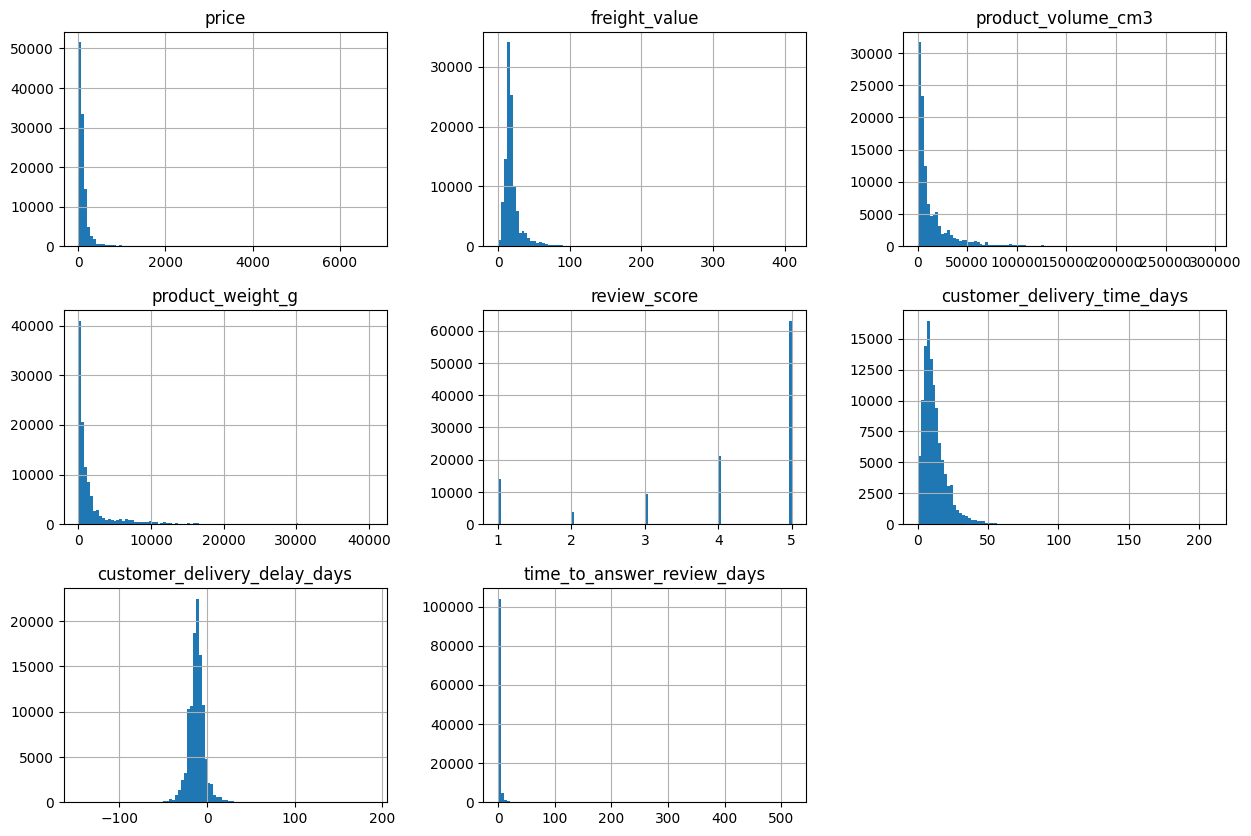

In [31]:
# plota as variáveis numéricas em histogramas
df.hist(column=['price',
                'freight_value',
                'product_volume_cm3',
                'product_weight_g',
                'review_score',
                'customer_delivery_time_days',
                'customer_delivery_delay_days',
                'time_to_answer_review_days'],
        figsize = (15,10), bins=100)
plt.show()

É possível perceber que o atributo customer_delivery_delay_days tem uma forma "normalizada" e review_score tem somente 5 valores possíveis como esperado.

Já os atributos price, freight_value, product_volume_cm3, product_weight_g, customer_delivery_time_days e time_to_answer_review_days têm uma distribuição assimétrica à direita (positiva). Portanto, é válido realizar uma transformação logarítmica nestes para avaliar a sua correlação. Mas primeiro será feita a análise de seus boxplots e correlação sem a transformação para entender o efeito que ela traz posteriormente.

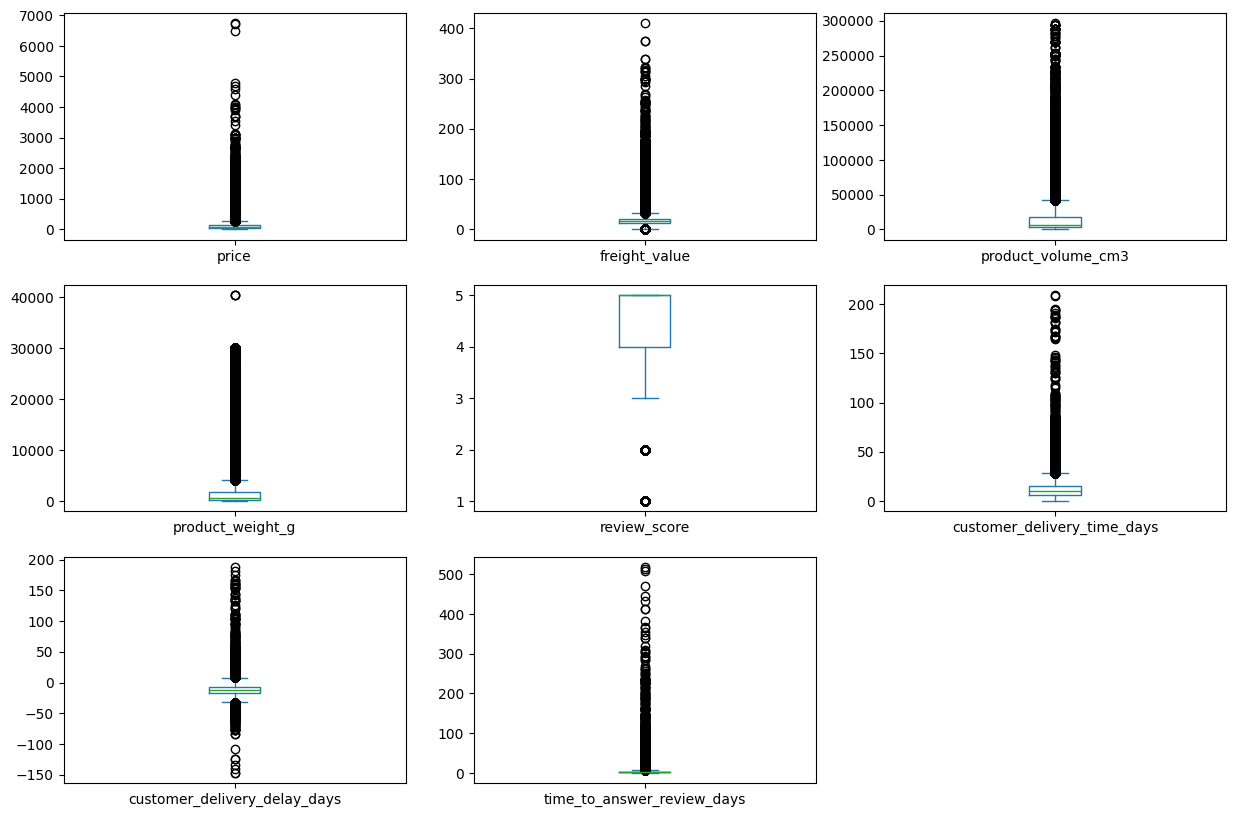

In [32]:
# boxplot
df.plot(kind = 'box', subplots = True, layout = (3,3), sharex = False, sharey = False, figsize = (15,10))
plt.show()

Como era esperado, os boxplots possuem muitos outliers destacados por conta da cauda alongada e concentração dos valores mais frequentes das distribuições.

review_score é o único que possui uma característica diferente. Observa-se que as notas 1 e 2 são consideradas outliers.

Como os outliers não representam valores impossíveis, são todos factíveis, não será aplicado nenhum tratamento para tais valores. Assumindo assim que são verídicos.

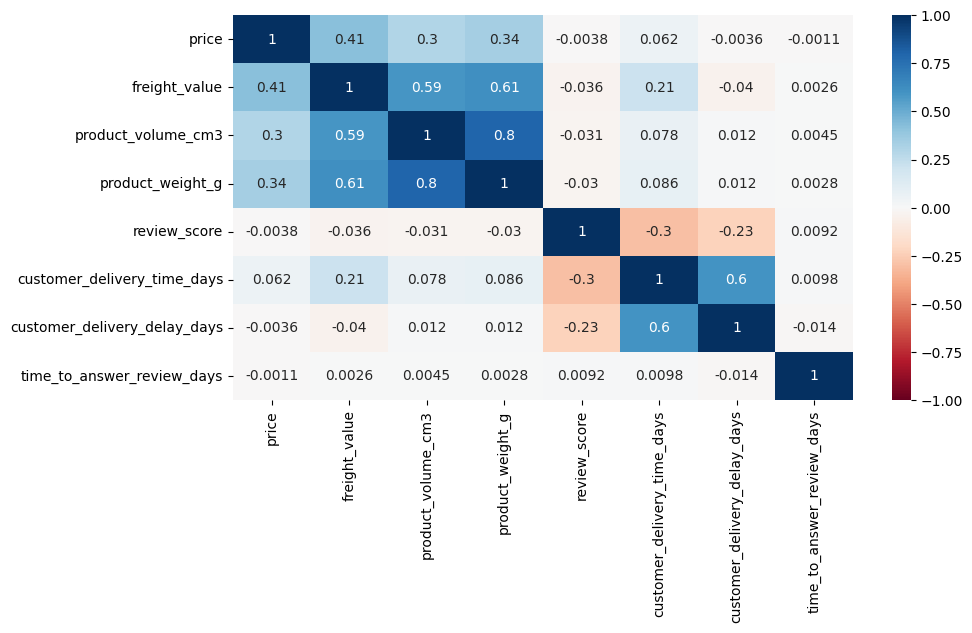

In [33]:
# Matriz de Correlação com Seaborn
plt.figure(figsize = (10,5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='RdBu', vmin=-1, vmax=1);

Apenas customer_delivery_time_days e customer_delivery_delay_days possuem correlação minimamente significativa com review_score.

In [34]:
# cria uma cópia do dataset original
df_log = df.copy()

# especifica quais colunas serão transformadas
cols_to_transform = ['price',
                     'freight_value',
                     'product_volume_cm3',
                     'product_weight_g',
                     'customer_delivery_time_days',
                     'time_to_answer_review_days']

# aplica a transformação logarítmica de base 10 nas colunas selecionadas
# é somado um valor mínimo a todos os valores para que os valores zero não resultem em -infinito após a transformação 
df_log[cols_to_transform] = np.log10(df_log[cols_to_transform] + 1e-8)

# atualiza o nome das colunas para indicar que a transformação logarítmica foi realizada
df_log.rename(columns={'price': 'price_log',
                       'freight_value': 'freight_value_log',
                       'product_volume_cm3': 'product_volume_cm3_log',
                       'product_weight_g': 'product_weight_g_log',
                       'customer_delivery_time_days': 'customer_delivery_time_days_log',
                       'time_to_answer_review_days': 'time_to_answer_review_days_log',},
              inplace=True)

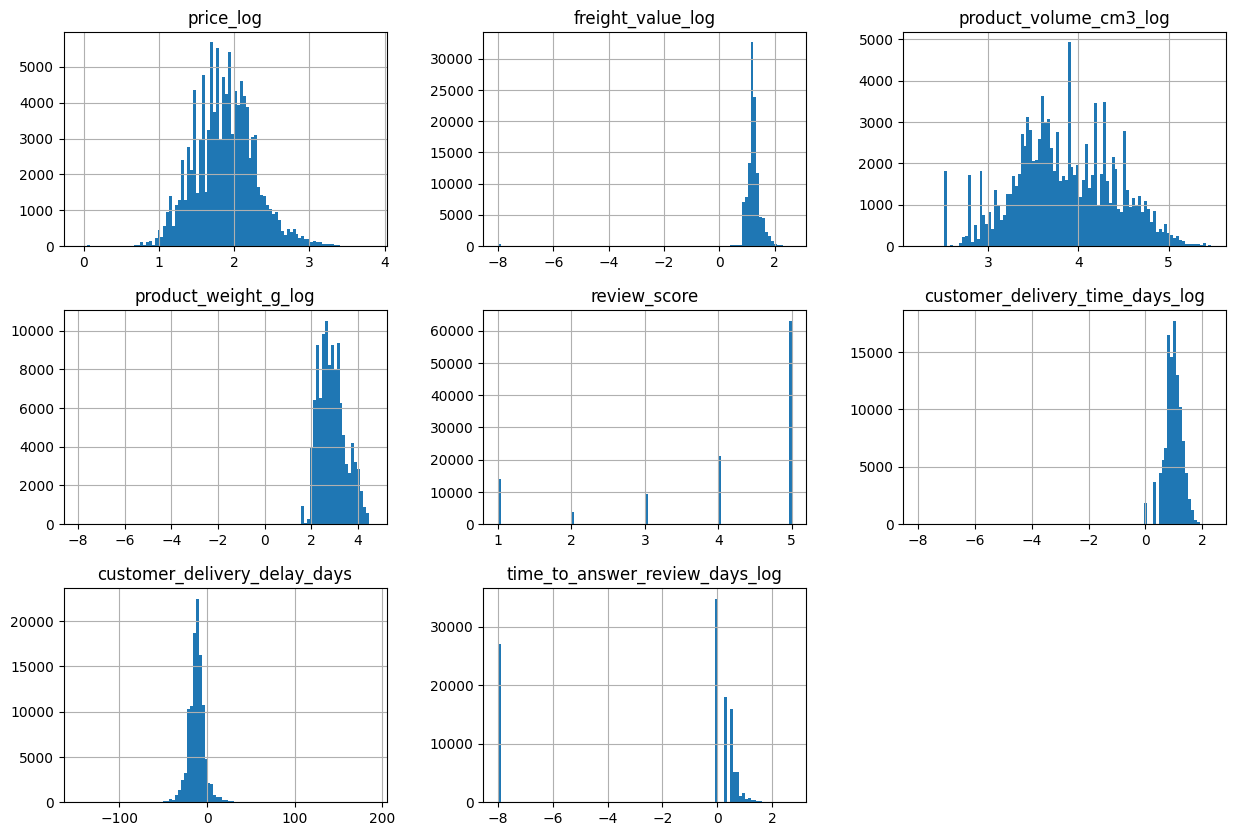

In [35]:
# plota em histogramas as variáveis numéricas transformadas
df_log.hist(column=['price_log',
                    'freight_value_log',
                    'product_volume_cm3_log',
                    'product_weight_g_log',
                    'review_score',
                    'customer_delivery_time_days_log',
                    'customer_delivery_delay_days',
                    'time_to_answer_review_days_log'],
            figsize = (15,10), bins=100)
plt.show()

Após a transformação logarítmica, é possível observar que as distribuições assumem um caráter mais normalizado.

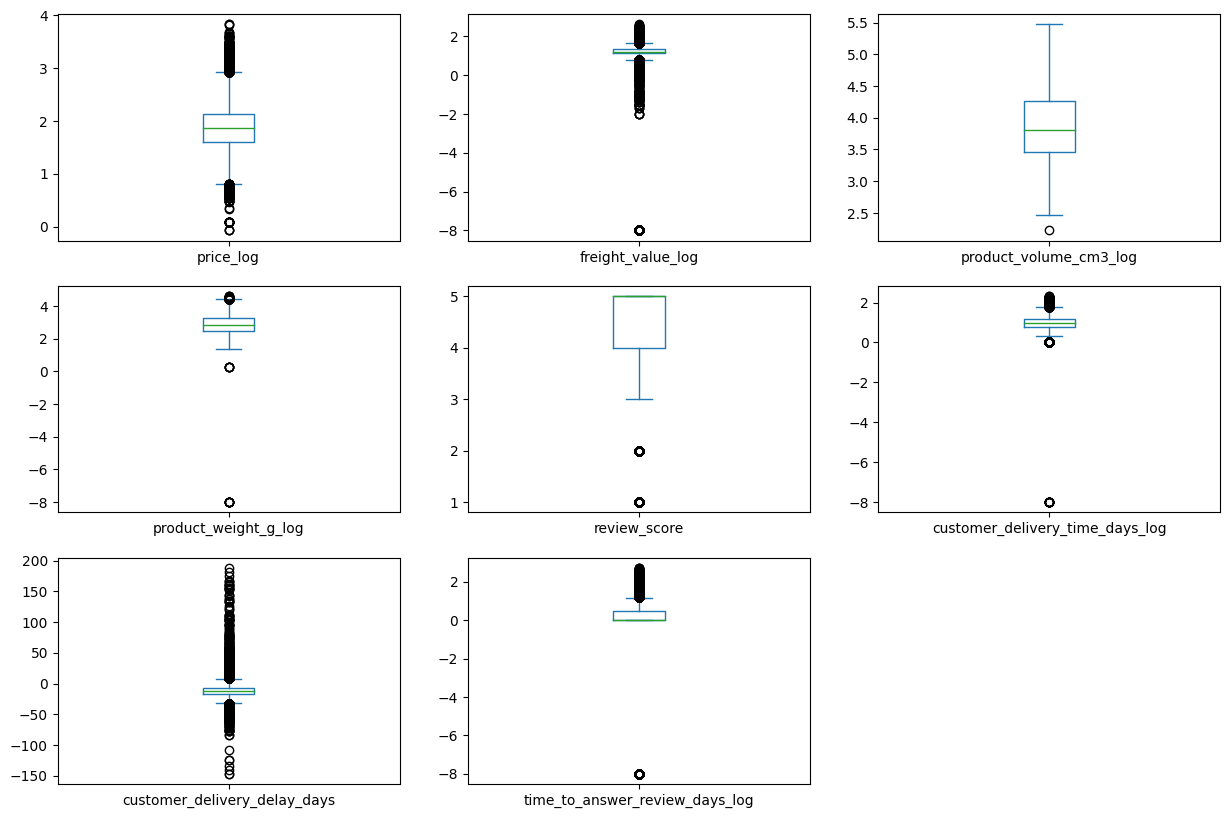

In [36]:
# boxplot das variáveis transformadas
df_log.plot(kind = 'box', subplots = True, layout = (3,3), sharex = False, sharey = False, figsize = (15,10))
plt.show()

Nota-se que a presença de outliers foi reduzida e as distribuições possuem um range de valores menor.

<Axes: >

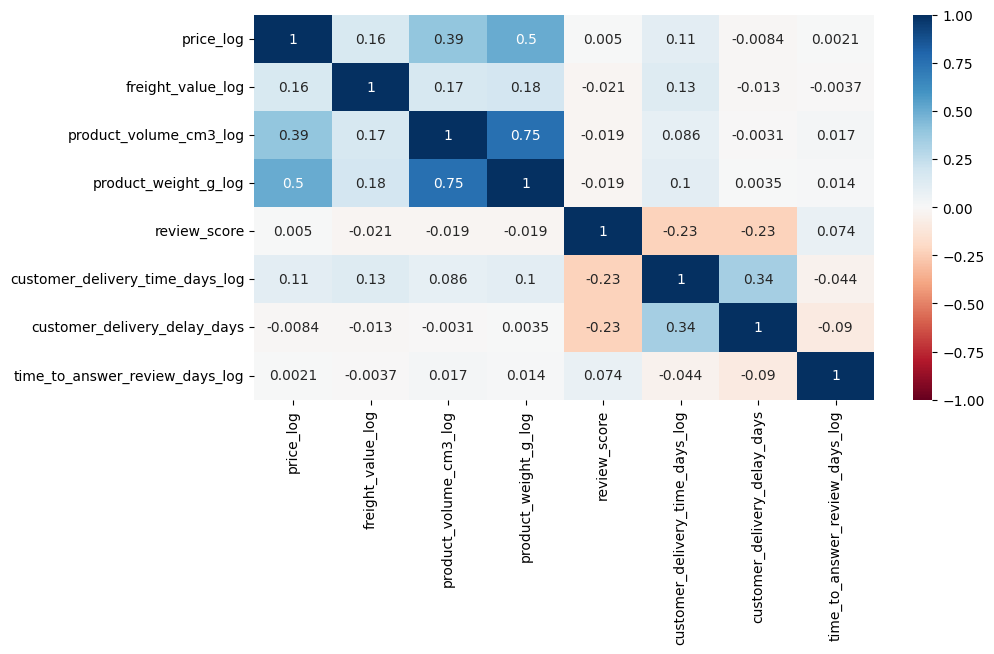

In [37]:
# Matriz de Correlação com Seaborn das variáveis transformadas
plt.figure(figsize = (10,5))
sns.heatmap(df_log.corr(numeric_only=True), annot=True, cmap='RdBu', vmin=-1, vmax=1)

Após a transformação logarítmica, as correlações de review_score com todos os atributos permaneceram próximas às originais. Todos os atributos, exceto customer_delivery_time_days e customer_delivery_delay_days, possuem correlação com review_score próxima de zero.

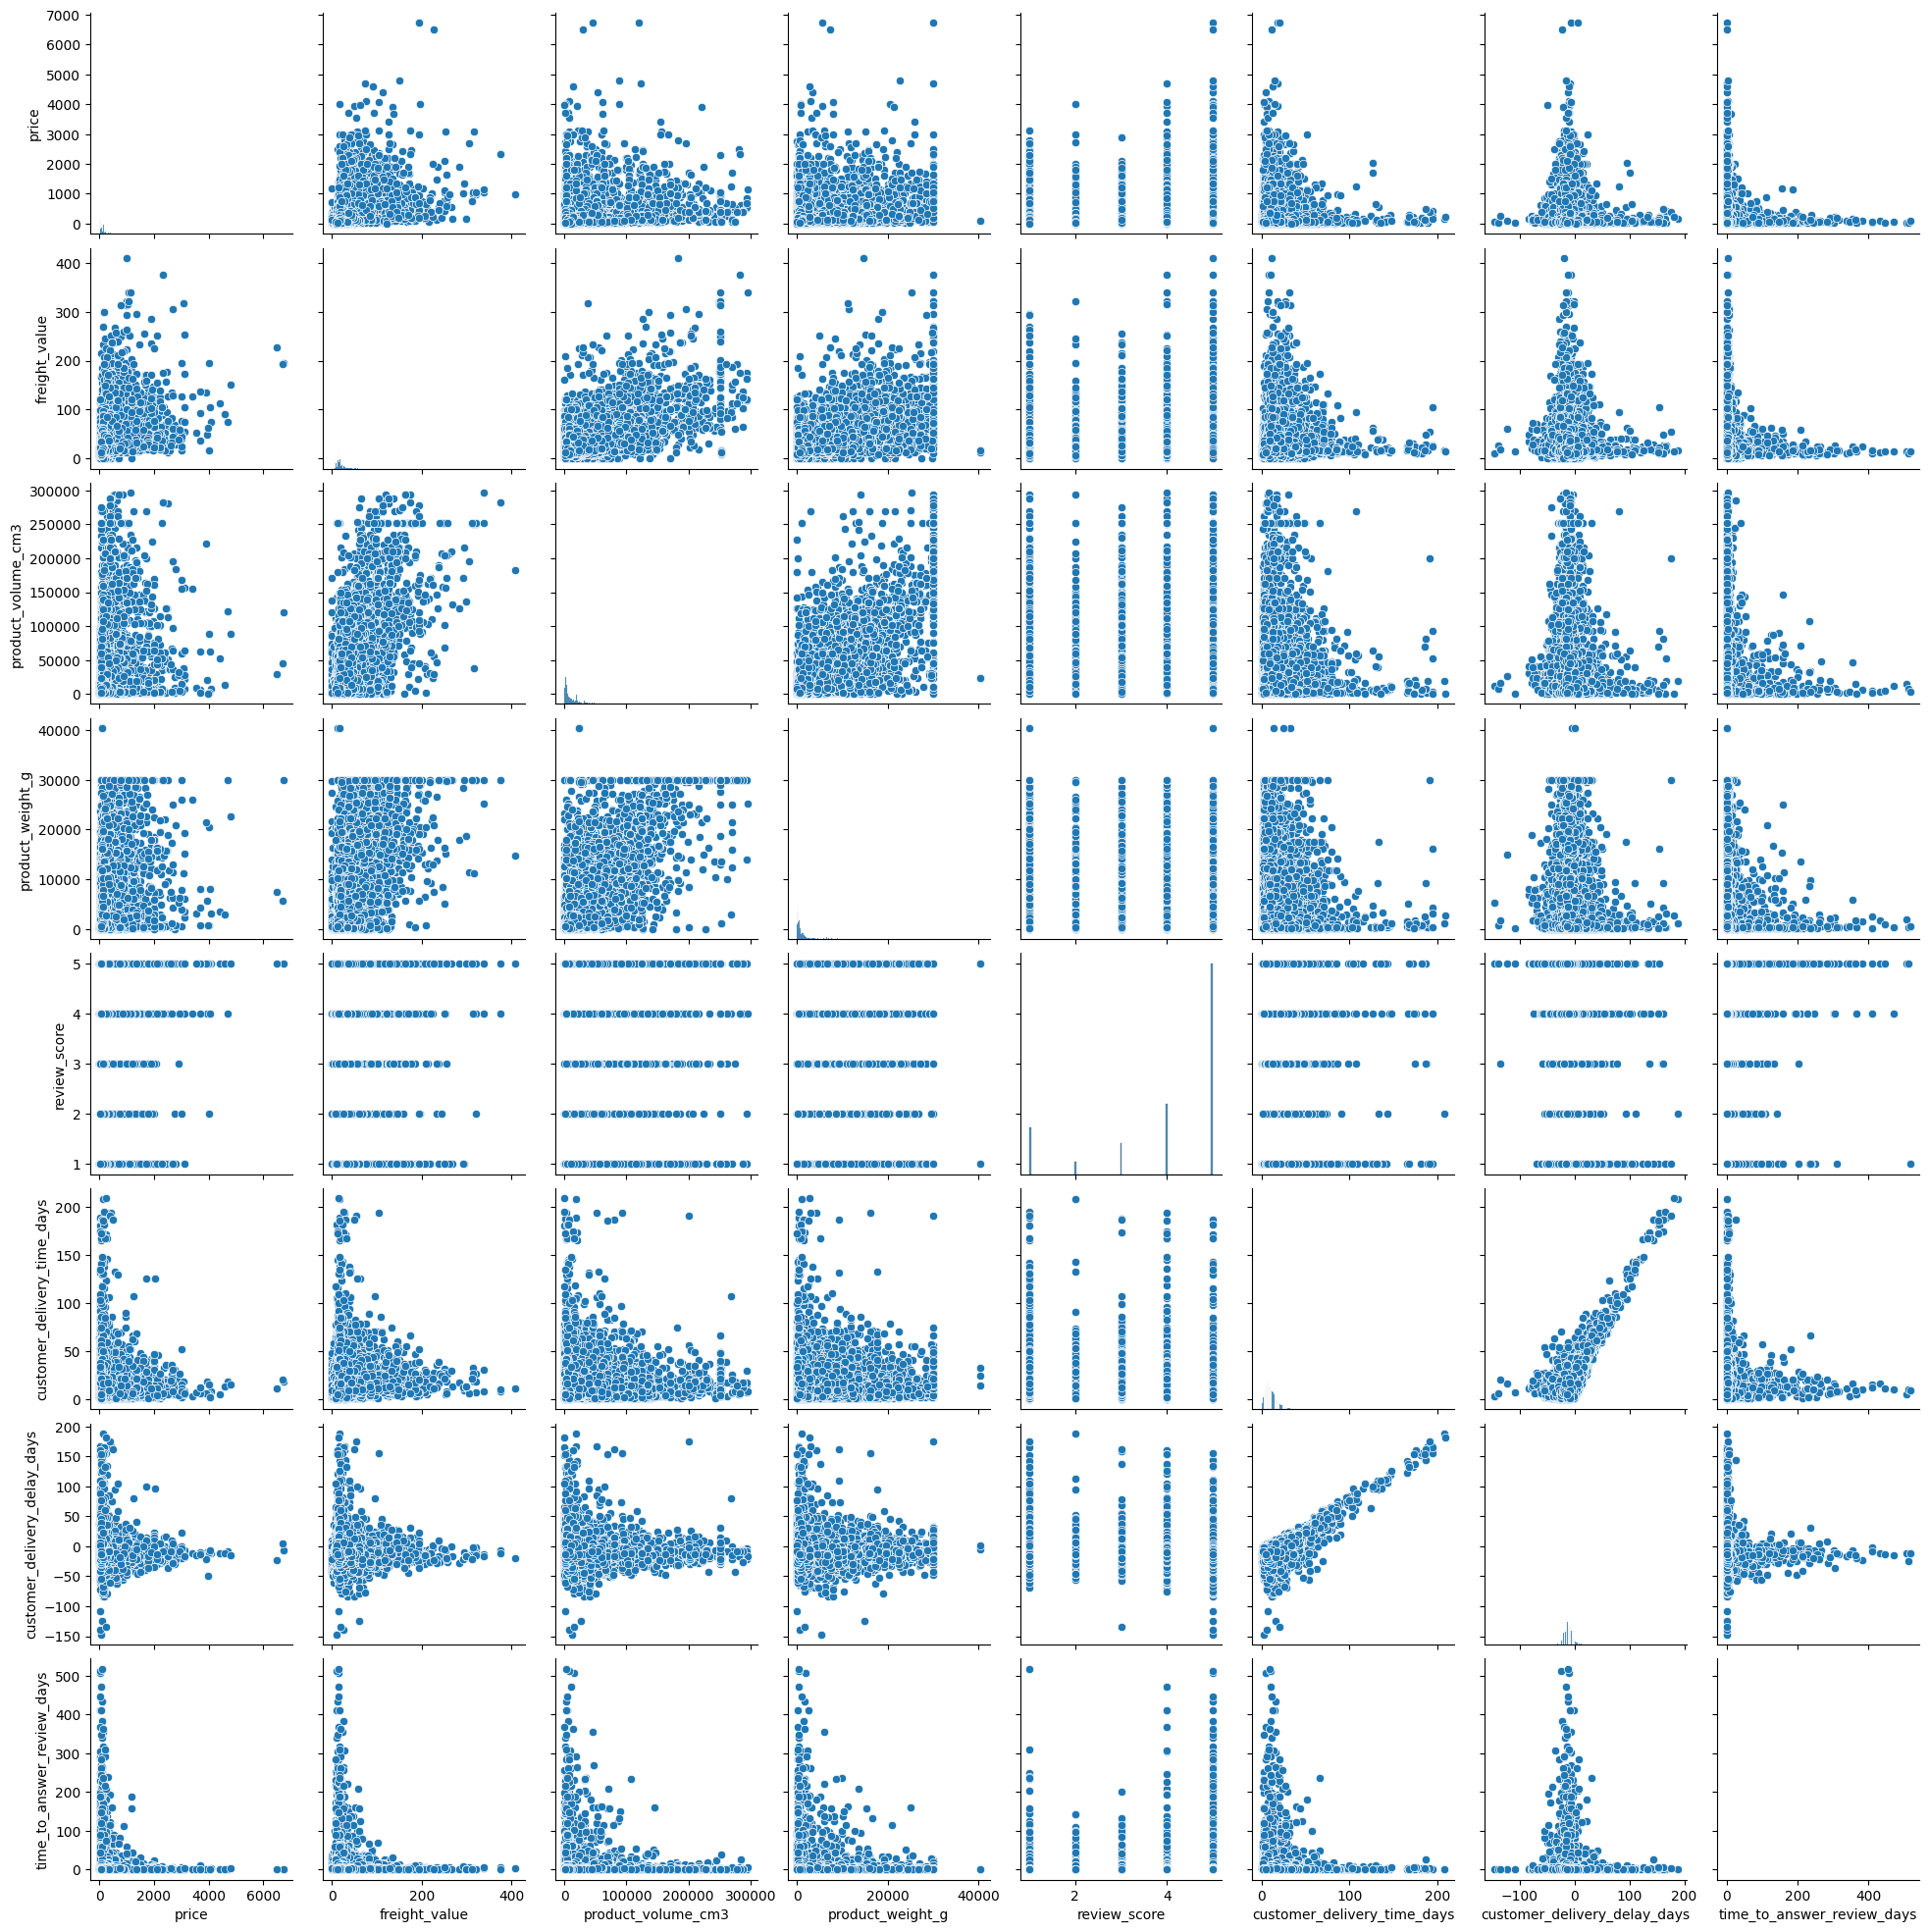

In [38]:
# Scatter Plot com Seaborn
sns.pairplot(df)

O único gráfico de dispersão de review_score que indica algum padrão é o gráfico com customer_delivery_delay_days. Neste gráfico, há um indicativo de uma maior concentração de notas melhores para entregas dentro do prazo ou realizadas com antecedência e uma maior concentração de notas piores para entregas com atraso.

Mesmo que a correlação entre a satisfação do cliente e atraso na entrega ao cliente seja baixa (0.23), é necessário investigar mais a fundo por causa da peculiaridade da situação de atraso. Uma hipótese é que uma vez atrasada a entrega, o nível de satisfação do cliente já tenha uma queda relevante independente dos dias de atraso.

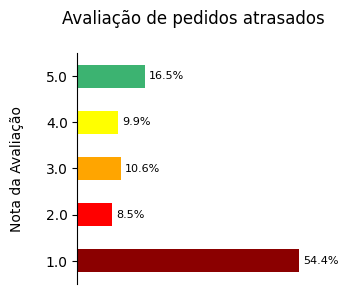

In [56]:
# calcula a soma de ocorrências de entregas atrasadas agrupando por nota da avaliação do cliente
group_sum = df[df['customer_delivery_delay_days'] > 0].groupby('review_score').size()

# calcula o percentual de ocorrência de cada grupo com duas casas decimais
group_percentage = round(group_sum / group_sum.sum() * 100, 2)

# cria uma tabela com a soma e o percentual de ocorrências por nota
late_delivery_score = pd.DataFrame({'late_delivery_count': group_sum, 'late_delivery_percentage': group_percentage})

# cria um gráfico de barras
ax = late_delivery_score.plot.barh(y='late_delivery_percentage',
                                  title='Avaliação de pedidos atrasados\n',
                                  ylabel='Nota da Avaliação\n',
                                  xticks=[],
                                  figsize=(3, 3), legend=False,
                                  color=['darkred', 'red', 'orange','yellow', 'mediumseagreen'])

# adiciona rótulos de dados em cada barra
for rect in ax.containers:
    ax.bar_label(rect, fmt='%.1f%%', fontsize=8, padding=3)
    
# remove as bordas do gráfico
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.show()

Uma análise simples das notas dadas aos pedidos em que houve atraso mostra que a relação entre essas variáveis é relevante. A tabela acima mostra que, dos pedidos em que ocorreu atraso na entrega, a maioria recebeu a pior nota e ~74% receberam nota 3 ou menor.

Dessa forma, é possível dizer que atrasos na entrega afetam de forma significativa a avaliação do cliente.

Para analisar as variáveis categóricas, incialmente serão listadas as médias das notas de avaliação por categoria:

In [40]:
# cria tabela com média de notas de avaliação do cliente por categorias de produto
category_score = pd.pivot_table(df,
                                values='review_score', 
                                index='product_category_name',
                                aggfunc='mean')

# ordena a tabela da pior para melhor média de notas
category_score.sort_values(by='review_score', inplace=True)

# mostra as 20 categorias com pior avaliação média
category_score.head(20)

,review_score
product_category_name,
seguros_e_servicos,2.500000
fraldas_higiene,3.256410
portateis_cozinha_e_preparadores_de_alimentos,3.266667
pc_gamer,3.333333
moveis_escritorio,3.491950
casa_conforto_2,3.629630
fashion_roupa_masculina,3.641221
telefonia_fixa,3.681992
fashion_roupa_feminina,3.750000


Das vinte categorias pior avaliadas, cinco se destacam com médias piores que 3.50.

In [41]:
# cria tabela com média de notas de avaliação do cliente por Estado
customer_state_score = pd.pivot_table(df,
                                      values='review_score', 
                                      index='customer_state',
                                      aggfunc='mean')

# ordena a tabela da pior para melhor média de notas
customer_state_score.sort_values(by='review_score', inplace=True)

# mostra a tabela
customer_state_score

,review_score
customer_state,
RR,3.576923
MA,3.701711
AL,3.721088
PA,3.791509
RJ,3.810488
CE,3.814588
BA,3.816070
SE,3.835509
PI,3.895717


A média das notas por Estado varia de ~3.6 a ~4.1. Sendo São Paulo a melhor nota e Roraima a pior.

É interessante ter uma visão por região do país também, já que parece que os Estados do Nordeste apresentam piores avaliações:

In [42]:
# cria um dicionário onde as chaves são as siglas dos Estados e os valores são a sua respectiva região
state_to_region = {'AC': 'N',
                    'AL': 'NE',
                    'AP': 'N',
                    'AM': 'N',
                    'BA': 'NE',
                    'CE': 'NE',
                    'DF': 'CO',
                    'ES': 'SE',
                    'GO': 'CO',
                    'MA': 'NE',
                    'MT': 'CO',
                    'MS': 'CO',
                    'MG': 'SE',
                    'PA': 'N',
                    'PB': 'NE',
                    'PR': 'S',
                    'PE': 'NE',
                    'PI': 'NE',
                    'RJ': 'SE',
                    'RN': 'NE',
                    'RS': 'S',
                    'RO': 'N',
                    'RR': 'N',
                    'SC': 'S',
                    'SP': 'SE',
                    'SE': 'NE',
                    'TO': 'N'}

# transforma a pivot table em um dataframe
customer_state_score = pd.DataFrame({'customer_state': customer_state_score.index, 'review_score': customer_state_score.values.flatten()})

# cria uma coluna 'customer_region' no dataframe com os valores do dicionário
customer_state_score['customer_region'] = customer_state_score['customer_state'].map(state_to_region)

# reordena as colunas do dataframe
customer_state_score = customer_state_score[['customer_region', 'customer_state', 'review_score']]

# mostra a tabela
customer_state_score

,customer_region,customer_state,review_score
0,N,RR,3.576923
1,NE,MA,3.701711
2,NE,AL,3.721088
3,N,PA,3.791509
4,SE,RJ,3.810488
5,NE,CE,3.814588
6,NE,BA,3.816070
7,NE,SE,3.835509
8,NE,PI,3.895717
9,NE,PE,3.954036


Dos dez Estados com piores notas, sete são do Nordeste. O único Estado da região que possui média de nota acima de 4.0 é o Rio Grande do Norte.

O Rio de Janeiro se destaca como pior nota da região Sudeste.

A região Norte tem a pior (Roraima) e a segunda melhor (Tocantins) nota.

In [43]:
# define uma função de agregação customizada que retorna a média dos valores se houver 10 ou mais ocorrências, caso contrário retorna nulo
def custom_mean(x):
    if len(x) >= 10:
        return np.mean(x)
    else:
        return np.nan
    
# cria uma pivot table relacionando as variáveis de categoria do produto e Estado do cliente
# os valores são a média das notas de avaliação do cliente caso haja 10 ou mais ocorrências
category_per_state_score = pd.pivot_table(df,
                                          values='review_score',
                                          index='product_category_name',
                                          columns='customer_state',
                                          aggfunc=custom_mean,
                                          margins=True,
                                          margins_name='Total')

category_per_state_score

customer_state,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,...,PR,RJ,RN,RO,RS,SC,SE,SP,TO,Total
product_category_name,,,,,,,,,,,,,,,,,,,,,
agro_industria_e_comercio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.916667,3.964286,NaN,NaN,NaN,NaN,NaN,4.168421,NaN,4.000000
alimentos,NaN,NaN,NaN,NaN,4.285714,NaN,NaN,4.000000,NaN,NaN,...,4.517241,4.170213,NaN,NaN,3.692308,3.937500,NaN,4.238267,NaN,4.218182
alimentos_bebidas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.375000,3.942308,NaN,NaN,NaN,NaN,NaN,4.474074,NaN,4.310469
artes,NaN,NaN,NaN,NaN,3.900000,NaN,NaN,NaN,NaN,NaN,...,NaN,3.969697,NaN,NaN,NaN,NaN,NaN,3.704082,NaN,3.937198
artes_e_artesanato,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,4.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tablets_impressao_imagem,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.222222,NaN,NaN,NaN,NaN,NaN,4.531250,NaN,4.123457
telefonia,NaN,3.714286,4.00000,NaN,3.504032,3.646465,4.095745,3.774775,4.048780,3.600000,...,4.052209,3.914153,3.960000,4.055556,4.013746,3.763006,3.500000,4.004887,3.809524,3.945922
telefonia_fixa,NaN,NaN,NaN,NaN,2.833333,NaN,NaN,NaN,NaN,NaN,...,NaN,3.138889,NaN,NaN,4.500000,NaN,NaN,3.820513,NaN,3.681992


In [44]:
# o método .stack() transforma a pivot table em uma série multi índice
# .reset_index() transforma os índices da série em colunas, transformando a série em um dataframe
worst_category_per_state_score = category_per_state_score.stack().reset_index()

# renomeia as colunas
worst_category_per_state_score.columns = ['product_category_name', 'customer_state', 'review_score']

# filtra linhas que review_score é nulo
worst_category_per_state_score = worst_category_per_state_score[worst_category_per_state_score['review_score'].notnull()]

# ordena review_score de menor para maior
worst_category_per_state_score.sort_values(by='review_score', inplace=True)

# mostra as 10 primeiras linhas
worst_category_per_state_score.head(10)

,product_category_name,customer_state,review_score
183,casa_construcao,CE,2.200000
177,casa_conforto,SC,2.666667
548,moveis_escritorio,PA,2.814815
701,telefonia_fixa,BA,2.833333
397,ferramentas_jardim,MA,2.833333
718,utilidades_domesticas,PB,3.043478
707,utilidades_domesticas,AL,3.100000
516,moveis_decoracao,AL,3.117647
416,fraldas_higiene,SP,3.129032
703,telefonia_fixa,RJ,3.138889


A tabela acima mostra as 10 piores categorias por Estado em que houve venda de pelo menos 10 itens. No entanto, como existem muitas categorias e muitos Estados, é importante obter uma visão mais holística:

Text(0.5, 190.7222222222222, 'Estado do cliente')

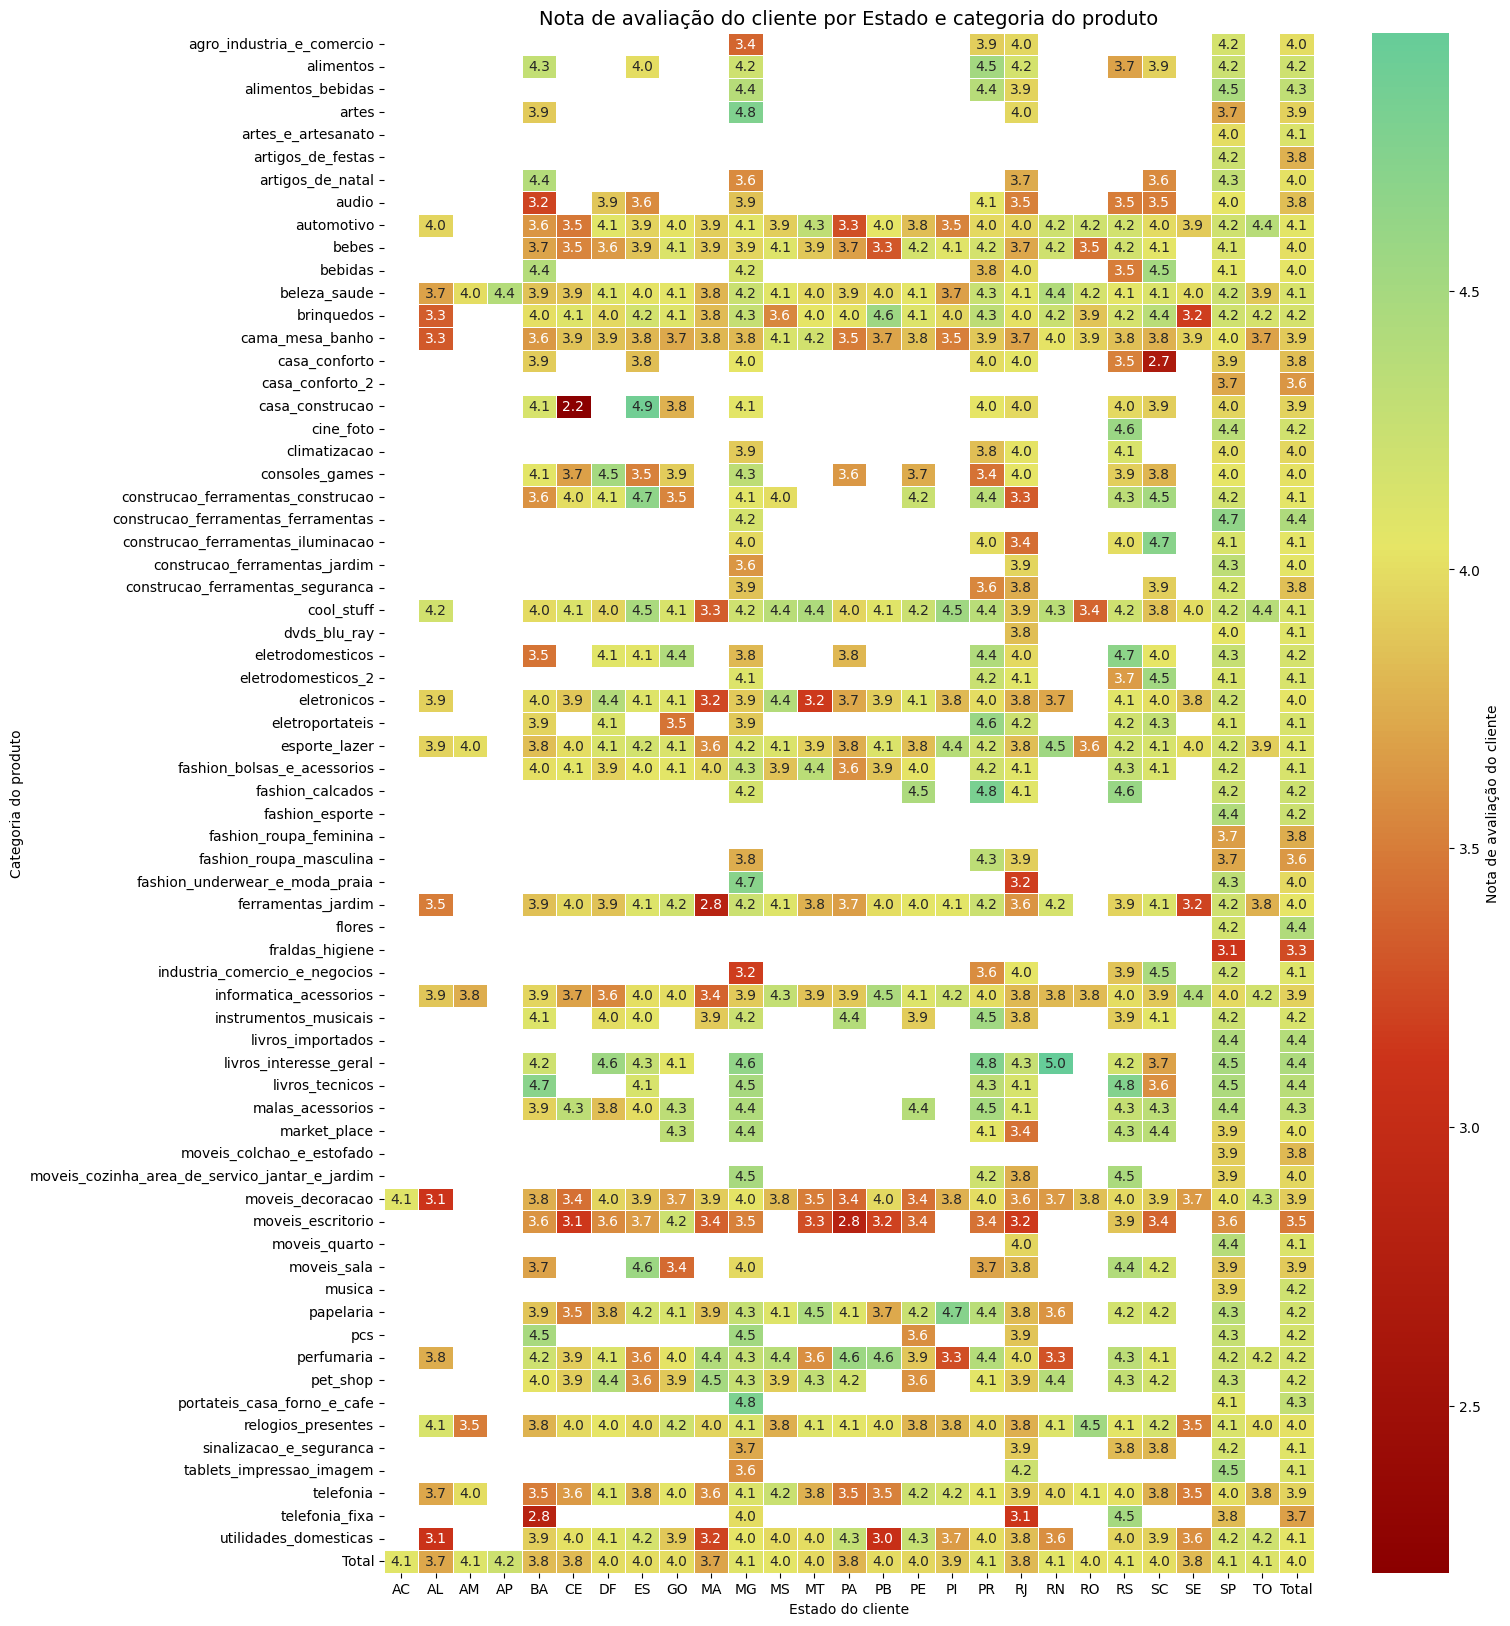

In [45]:
plt.figure(figsize=(15, 20))

# cria uma paleta sequencial customizada do vermelho escuro, ao laranja, amarelo e verde
colors = ["darkred", (0.8, 0.2, 0.1), (0.9, 0.9, 0.4), (0.4, 0.8, 0.6)]
cmap = sns.blend_palette(colors, as_cmap=True)

# heatmap 
sns.heatmap(category_per_state_score,
            cmap=cmap,
            annot=True,
            fmt=".1f",
            linewidths=.5,
            cbar_kws={'label': 'Nota de avaliação do cliente'})

# define o título do gráfico e nome dos eixos
plt.title('Nota de avaliação do cliente por Estado e categoria do produto', fontsize=14)
plt.ylabel('Categoria do produto')
plt.xlabel('Estado do cliente')

Com este gráfico, temos uma visão holística dos atributos categóricos e podemos fazer algumas observações.

Analisando as notas por Estado, nota-se que o Rio de Janeiro possui piores notas que São Paulo e Minas Gerais na maioria das categorias, o que não deveria ocorrer pela proximidade e característica semelhante de grandes centros urbanos. Seria necessário investigar mais a fundo para entender quais fatores levam a essa diferença. Os clientes são mais criteriosos? Os fornecedores entregam produtos piores? Atrasam mais?

Roraima não é mostrado por não ter nenhuma categoria com mais de 10 itens vendidos.

Cinco Estados do Nordeste aparecem com nota 3.8 ou pior. Esses Estados apresentam notas baixas na maioria de suas categorias, indicando que pode ser um problema específico dos Estados como logística, por exemplo.

Algumas categorias têm problemas na maioria dos Estados, como é o caso de móveis de escritório, cama/mesa/banho, movéis/decoração e informática/acessórios. Os produtos ofertados são de má qualidade? O preço é caro para o produto que é entregue? 

Como nesta visualização não se tem a noção da importância de cada categoria por Estado para o negócio, fica difícil definir prioridades. Assim, em um âmbito corporativo, seria interessante que essa visualização mostrasse o total de vendas de cada célula para o gestor direcionar os esforços de acordo com a estratégia definida.

In [46]:
# cria uma pivot table com valores de total de vendas e média de nota de avaliação por categoria e Estado
category_per_state_score_wsales = df.pivot_table(index='customer_state', columns='product_category_name', 
                             values=['review_score', 'price'], aggfunc={'review_score': custom_mean, 'price': 'sum'})

# transforma a pivot table em dataframe
category_per_state_score_wsales = category_per_state_score_wsales.stack(level=['product_category_name']).reset_index()

# renomeia as colunas
category_per_state_score_wsales.columns = ['customer_state', 'product_category_name', 'sales_total', 'review_score']

# transforma o valor total das vendas de R$ para R$ mil
category_per_state_score_wsales['sales_total'] = (category_per_state_score_wsales['sales_total'] / 1000)

category_per_state_score_wsales

,customer_state,product_category_name,sales_total,review_score
0,AC,artigos_de_natal,0.06990,NaN
1,AC,automotivo,0.54098,NaN
2,AC,bebes,0.69784,NaN
3,AC,beleza_saude,1.38658,NaN
4,AC,brinquedos,0.23479,NaN
...,...,...,...,...
1363,TO,portateis_casa_forno_e_cafe,1.99900,NaN
1364,TO,relogios_presentes,5.44689,4.000000
1365,TO,telefonia,1.26812,3.809524
1366,TO,telefonia_fixa,1.39099,NaN


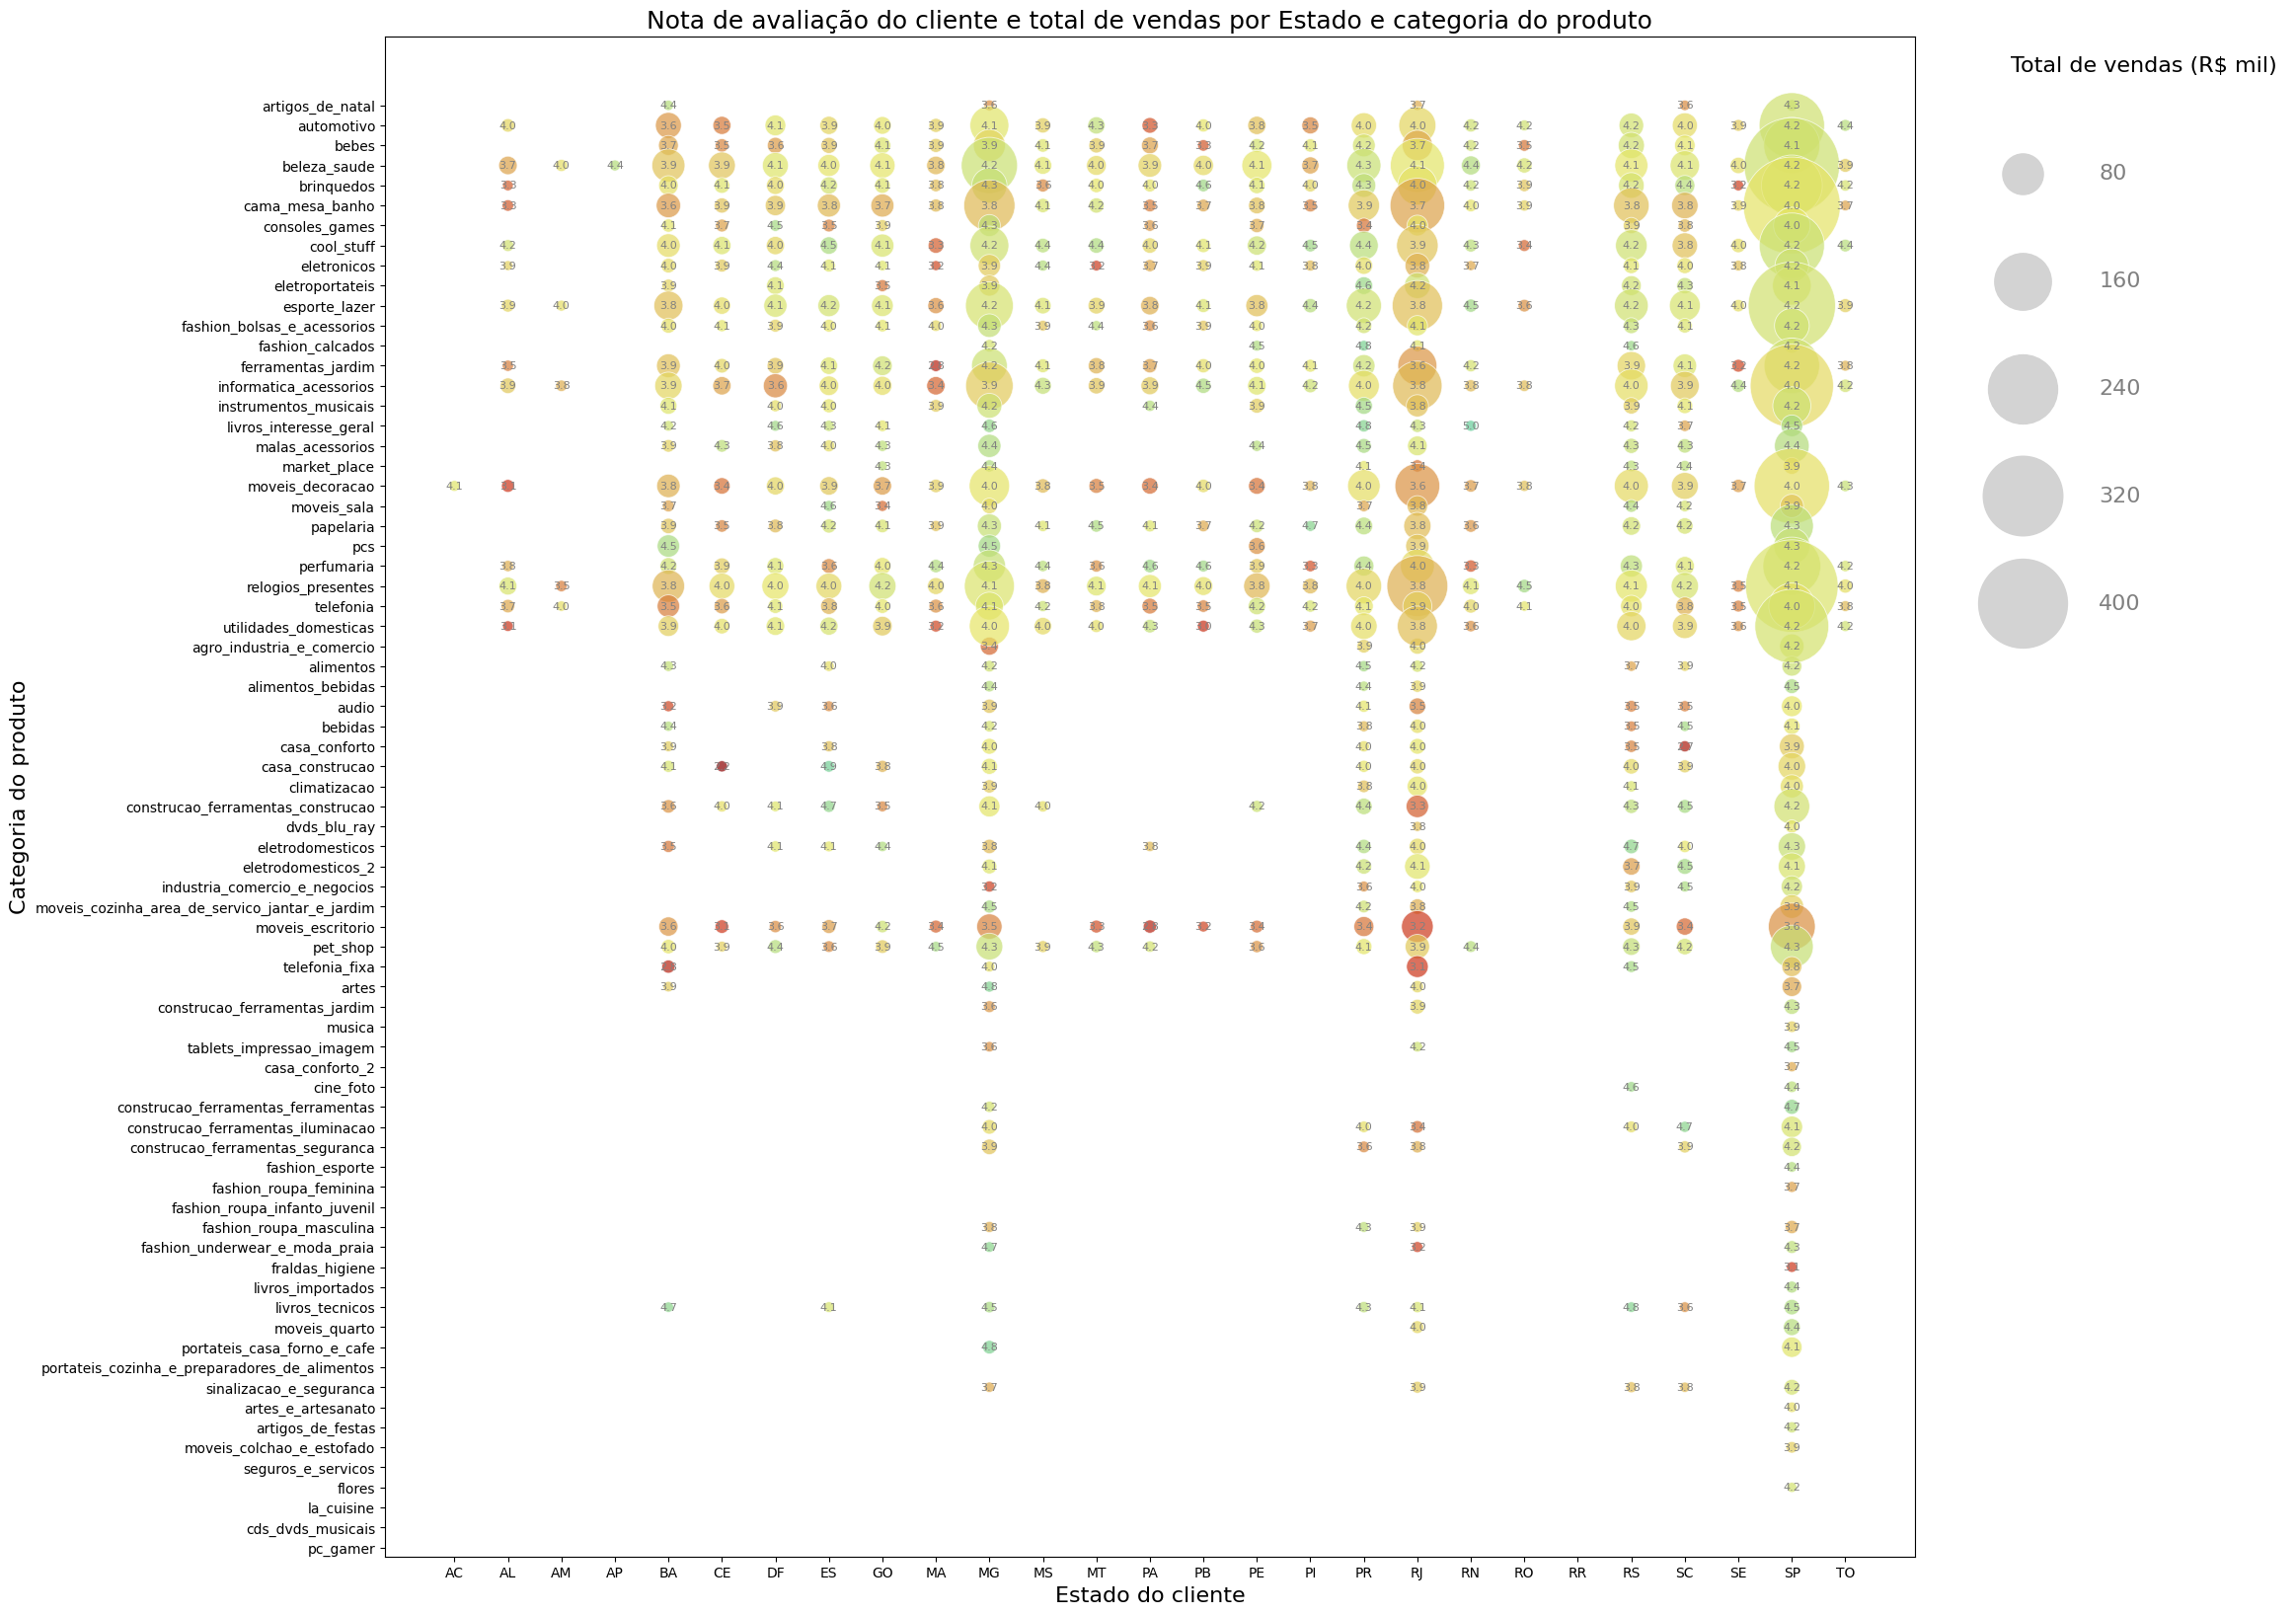

In [47]:
# define o tamanho do gráfico
plt.figure(figsize=(20, 20))

# cria um scatterplot com a categoria do produto no eixo y, o Estado no eixo x,
# o volume das bolhas como o total de vendas e a cor como a nota de avaliação
scatter = sns.scatterplot(data=category_per_state_score_wsales, x='customer_state', y='product_category_name',
                          hue='review_score', size='sales_total',
                          palette=cmap, sizes=(50, 5000), alpha=0.7)

# percorre as linhas do dataframe
for i, row in category_per_state_score_wsales.iterrows():
    # extrai os valores das linhas
    x = row['customer_state']
    y = row['product_category_name']
    s = row['sales_total']
    r = row['review_score']
    
    # adiciona o rótulo de dados com os valores de review_score
    if not pd.isna(r):
        plt.annotate(round(r, 1), xy=(x, y), ha='center', va='center', fontsize=8, color='gray')

# define o título do gráfico e nome dos eixos
plt.title('Nota de avaliação do cliente e total de vendas por Estado e categoria do produto', fontsize=18)
plt.xlabel('Estado do cliente', fontsize=16)
plt.ylabel('Categoria do produto', fontsize=16)

# cria uma variável contendo os handles e labels da legenda
handles, labels = scatter.get_legend_handles_labels()

# percorre os handles e define a cor cinza claro de face e borda para cada um deles
for handle in handles:
    handle.set_facecolor('lightgray')
    handle.set_edgecolor('lightgray')

# customiza a legenda
plt.legend(handles[7:], labels[7:], labelspacing=4.0, handletextpad=3.0, alignment='left',
           labelcolor='gray', handlelength=1.0, 
           title='Total de vendas (R$ mil)', title_fontsize=16,
           bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16, frameon=False)

# plota o gráfico
plt.show()

Com esta visualização, se obtém uma visão geral dos atributos categóricos e também da sua relevância para o negócio.

São Paulo é o estado com mais vendas. Rio de Janeiro e Minas Gerais vêm atrás e, em um terceiro escalão, estão Bahia e os três estados do Sul do país.

É visível que existe uma concentração de vendas muito grande na região sudeste, principalmente em São Paulo. Além disso, a região Sul é bem representada comparativamente ao restante. Fica evidente que uma direção para crescer é expandir a geografia para as outras regiões do país.

Rio de Janeiro chama a atenção pelas notas ruins e total de vendas relevante.

As maiores categorias são automotivo, bebês, beleza/saúde, brinquedos, cama/mesa/banho, "cool stuff", esporte/lazer, ferramentas/jardim, acessórios de informática, movéis de decoração, papelaria, perfumaria, relógios/presentes, telefonia, utilidades domésticas, móveis de escritório e petshop. Percebe-se também que essas categorias são as maiores na maioria dos Estados com vendas relevantes, o que sugere um padrão de consumo do cliente ao longo do país.

Algumas categorias que têm problemas na maioria dos Estados são relevantes, como é o caso de móveis de escritório, cama/mesa/banho, movéis/decoração e informática/acessórios. Seria interessante que a gestão alocasse esforços nessas categorias.

Para facilitar a visualização, uma saída possível seria agrupar categorias de produtos já que existem muitas delas e diversas parecem redundantes como "contrucao_ferramentas_contrucao", "construcao_ferramentas_iluminacao" e "construcao_ferramentas_seuranca" ou "cds_dvds_musicais" e "dvds_blu_ray". O rearranjo das categorias deve ser feito por pessoas com conhecimento do negócio de acordo com a análise que se deseja.

Outra saída possível para facilitar a visualização seria mostrar somente as categorias com vendas acima de um determinado valor. No entanto, isso omite a visão do todo do negócio e pode ocultar categorias promissoras importantes para o crescimento futuro.

## Conclusão

A partir do conjunto de dados, foi realizada uma análise exploratória a fim de entender quais fatores mais afetam a satisfação dos clientes.

Para isso, foram definidas as seguintes hipóteses:
* Produtos mais caros tendem a ter uma avaliação mais criteriosa dos clientes.
* Produtos com maior custo de frete tendem a ter uma avaliação mais baixa.
* Produtos maiores e mais pesados tendem a ter maior dificuldade de entrega, o que pode gerar mais atrasos, eventuais danos ao produto e maior insatisfação.
* Um alto prazo de entrega ao cliente gera insatisfação.
* Atrasos na entrega afetam a satisfação do cliente.
* Reviews feitos com maior tempo após o recebimento do produto acarretam em mais testes, maior percepção de problemas e maior insatisfação.
* Algumas categorias são pior avaliadas do que outras. O que pode ocorrer por fatores diversos como qualidade do produto ou precificação inadequada.
* A localização do cliente é relevante na sua avaliação. Isso pode ocorrer por diversos fatores como mudança da qualidade dos produtos disponíveis, da exigência do cliente e da logística de uma geografia para outra.


Assim, os seguintes atributos foram analisados, sendo oito quantitativos e dois categóricos:
1. price - Q
2. freight_value - Q
3. customer_state - C
4. product_category_name - C
5. product_volume_cm3 - Q
6. product_weight_g - Q
7. review_score - Q
8. customer_delivery_time_days - Q
9. customer_delivery_delay_days - Q
10. time_to_answer_review_days - Q

Após análise das distribuições (histogramas, boxplot e pairplot) e cálculo da correlação entre review_score e os demais atributos quantitativos, notou-se que somente o tempo de atraso do pedido possuía alguma correlação com a nota de avaliação dada pelo cliente. Dessa forma, a análise desse atributo e sua relação com a nota de avaliação foi aprofundada. Considerando os pedidos em que houve atraso, independente do número de dias de atraso, a maioria recebeu a pior nota e ~74% receberam nota 3 ou menor. Assim demonstrando a forte relação entre as duas variáveis.

Quanto às variáveis categóricas, foram desenvolvidas visualizações para identificar padrões. Foi percebido que existem Estados com padrão de consumo e localização semelhantes mas com notas médias distintas, como é o caso de Rio de Janeiro e Minas Gerais, por exemplo. Onde o Rio possui avaliação pior na grande maioria das categorias de produtos. Também se notou que existem categorias com notas abaixo da média em todos os Estados, como é o caso de móveis de escritório com somente um Estado com nota média acima de 4.0. Algumas dúvidas que não podem ser esclarecidas com os dados fornecidos surgiram da análise destas variáveis. Os clientes são mais criteriosos em alguns Estados? Os produtos ofertados em determinada categoria são de má qualidade? O preço é caro para o produto que é entregue?

Por fim, foi sugerida uma visualização para acompanhamento destas variáveis categóricas considerando a sua relevância para o negócio em termos de vendas. Assim, seria possível para o gestor direcionar os esforços de acordo com a estratégia da Companhia.

Portanto, foi possível identificar que os atrasos nas entregas possuem um papel importante na avaliação dada pelos clientes e que as variáveis categóricas dão pistas para problemas no negócio que precisariam ser investigados com mais dados.

## Sugestão futura

Como visto, a estimativa de tempo de entrega ao cliente é pouco assertiva. Portanto, é plausível realizar uma modelagem preditiva dessa variável a fim de obter estimativas melhores.

Este seria um modelo de aprendizado supervisionado, visto que há dados de entrada e saídas conhecidas. Uma abordagem para a etapa de pré processamento de dados seria normalizar os dados de entrada (input) para prever customer_delivery_time_days (output) com um modelo de regressão utilizando a biblioteca scikit-learn.

Considerando o dataset, pode-se utilizar uma abordagem de holdout temporal selecionando dados de compra até dez/17 para o conjunto de treinamento e após para o conjunto de teste. É importante realizar a transformação no conjunto de teste e no conjunto de treino separadamente para não ocorrer data leakage.

In [48]:
# cria uma cópia do dataset original
df_norm = df.copy()

# separa o dataset em conjuntos de treino e teste
df_norm_training = df_norm[df_norm['order_purchase_timestamp']<='2018-01-01 00:00:00'].copy()
df_norm_test = df_norm[df_norm['order_purchase_timestamp']>'2018-01-01 00:00:00'].copy()

# lista atributos de input para o modelo
input_var = ['price',
             'freight_value',
             'product_volume_cm3',
             'product_weight_g']

# percorre os atributos de input
for var in input_var:
    # aplica a transformação nas colunas selecionadas do conjunto de treino
    df_norm_training[var] = MinMaxScaler().fit_transform(df_norm_training[var].values.reshape(-1, 1))
    # aplica a transformação nas colunas selecionadas do conjunto de teste
    df_norm_test[var] = MinMaxScaler().fit_transform(df_norm_test[var].values.reshape(-1, 1))

In [49]:
df_norm_training.describe(include='all', datetime_is_numeric=True)

,order_id,product_id,price,freight_value,customer_id,order_purchase_timestamp,order_estimated_delivery_date,order_delivered_customer_date,order_status,customer_city,customer_state,product_category_name,product_volume_cm3,product_weight_g,review_score,review_creation_date,review_answer_timestamp,customer_delivery_time_days,customer_delivery_delay_days,time_to_answer_review_days
count,51234,51234,51234.000000,51234.000000,51234,51234,51234,49877,51234,51234,51234,50315,51216.000000,51216.000000,50750.0000,50750,50750,49877.000000,49877.00000,50750.000000
unique,44891,17451,NaN,NaN,44891,NaN,NaN,NaN,7,3279,27,72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,8272b63d03f5f79c56e9e4120aec44ef,99a4788cb24856965c36a24e339b6058,NaN,NaN,fc3d1daec319d62d49bfb5e1f83123e9,NaN,NaN,NaN,delivered,sao paulo,SP,cama_mesa_banho,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,21,359,NaN,NaN,21,NaN,NaN,NaN,49873,7319,20170,5231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,0.017809,0.061725,NaN,2017-08-13 17:14:47.246691584,2017-09-07 16:19:06.738493952,2017-08-27 14:49:40.976281600,NaN,NaN,NaN,NaN,0.055234,0.053145,4.0480,2017-08-26 22:57:13.726108416,2017-08-30 09:29:46.503526912,12.500812,-12.59358,2.880217
min,NaN,NaN,0.000000,0.000000,NaN,2016-09-04 21:15:19,2016-10-04 00:00:00,2016-10-11 13:46:32,NaN,NaN,NaN,NaN,0.000000,0.000000,1.0000,2016-10-06 00:00:00,2016-10-07 18:32:28,0.000000,-140.00000,0.000000
25%,NaN,NaN,0.005747,0.042525,NaN,2017-05-29 21:46:54,2017-06-23 00:00:00,2017-06-12 12:57:51,NaN,NaN,NaN,NaN,0.009377,0.006192,4.0000,2017-06-10 00:00:00,2017-06-14 08:35:32.750000128,7.000000,-17.00000,1.000000
50%,NaN,NaN,0.010605,0.051050,NaN,2017-08-29 11:10:57,2017-09-21 00:00:00,2017-09-11 19:35:42,NaN,NaN,NaN,NaN,0.024950,0.018576,5.0000,2017-09-12 00:00:00,2017-09-13 23:25:47,11.000000,-13.00000,1.000000
75%,NaN,NaN,0.019803,0.063709,NaN,2017-11-13 12:01:25.249999872,2017-12-05 00:00:00,2017-11-25 12:57:05,NaN,NaN,NaN,NaN,0.066432,0.044180,5.0000,2017-11-25 00:00:00,2017-11-28 17:56:45.249999872,15.000000,-8.00000,3.000000
max,NaN,NaN,1.000000,1.000000,NaN,2017-12-31 23:29:31,2018-04-06 00:00:00,2018-05-21 18:22:18,NaN,NaN,NaN,NaN,1.000000,1.000000,5.0000,2018-03-17 00:00:00,2018-10-10 00:13:35,209.000000,181.00000,518.000000


In [50]:
df_norm_test.describe(include='all', datetime_is_numeric=True)

,order_id,product_id,price,freight_value,customer_id,order_purchase_timestamp,order_estimated_delivery_date,order_delivered_customer_date,order_status,customer_city,customer_state,product_category_name,product_volume_cm3,product_weight_g,review_score,review_creation_date,review_answer_timestamp,customer_delivery_time_days,customer_delivery_delay_days,time_to_answer_review_days
count,61416,61416,61416.000000,61416.000000,61416,61416,61416,60319,61416,61416,61416,60732,61416.000000,61416.000000,60958.000000,60958,60958,60319.000000,60319.000000,60958.000000
unique,53775,20495,NaN,NaN,53775,NaN,NaN,NaN,5,3276,27,72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,1b15974a0141d54e36626dca3fdc731a,aca2eb7d00ea1a7b8ebd4e68314663af,NaN,NaN,be1b70680b9f9694d8c70f41fa3dc92b,NaN,NaN,NaN,delivered,sao paulo,SP,beleza_saude,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,20,413,NaN,NaN,20,NaN,NaN,NaN,60324,10489,27279,5951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,0.017748,0.049984,NaN,2018-04-28 00:53:16.777956864,2018-05-20 22:22:44.595545088,2018-05-10 06:36:08.258558720,NaN,NaN,NaN,NaN,0.047355,0.049686,4.020243,2018-05-10 02:02:26.225269760,2018-05-12 23:28:46.664605184,11.599993,-11.564350,2.317612
min,NaN,NaN,0.000000,0.000000,NaN,2018-01-01 02:48:41,2018-01-18 00:00:00,2018-01-04 12:23:09,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,2018-01-05 00:00:00,2018-01-05 15:15:27,0.000000,-147.000000,0.000000
25%,NaN,NaN,0.005811,0.031415,NaN,2018-02-27 16:25:24.249999872,2018-03-21 00:00:00,2018-03-16 14:51:02.500000,NaN,NaN,NaN,NaN,0.008891,0.006259,4.000000,2018-03-16 00:00:00,2018-03-18 23:10:09.500000,6.000000,-17.000000,0.000000
50%,NaN,NaN,0.011095,0.041105,NaN,2018-04-25 17:06:49.500000,2018-05-18 00:00:00,2018-05-07 23:21:11,NaN,NaN,NaN,NaN,0.019133,0.014842,5.000000,2018-05-08 00:00:00,2018-05-10 18:38:22.500000,9.000000,-12.000000,1.000000
75%,NaN,NaN,0.019939,0.054067,NaN,2018-06-26 14:47:07.750000128,2018-07-23 00:00:00,2018-07-04 23:25:11,NaN,NaN,NaN,NaN,0.054236,0.043290,5.000000,2018-07-05 18:00:00,2018-07-08 16:21:45.500000,15.000000,-7.000000,3.000000
max,NaN,NaN,1.000000,1.000000,NaN,2018-09-03 09:06:57,2018-10-25 00:00:00,2018-10-17 13:22:46,NaN,NaN,NaN,NaN,1.000000,1.000000,5.000000,2018-08-31 00:00:00,2018-10-29 12:27:35,208.000000,188.000000,264.000000
